# Section 5: deep reinforcement learning with the openai gym

### Installing the OpenAI gym
There are multiple ways you can install the OpenAI gym environment. 
##### In our Docker image
It is already installed in our Docker image. This means you don't have to do anything to include it, and you can start playing immediately. The downside of this is that there is no screen attached to our Docker image, which gives a bit of hassle inline. 
##### On your own pc. 
If you do want to see a screen with your game you would have to install everything locally. This means you have your own version of Python, TensorFlow, Matplotlib, etc. installed. If this is all fine you can install the OpenAI gym with this command. 

For more information: see [this site](https://github.com/openai/gym#installing-everything). 

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

from ipywidgets import widgets
from IPython.display import display


import gym



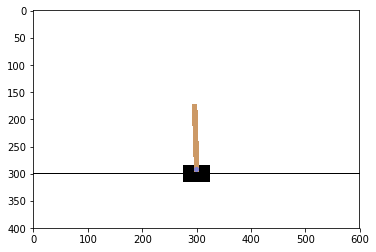

In [2]:
env = gym.make('CartPole-v0')
observation = env.reset()
firstframe = env.render(mode = 'rgb_array')
fig,ax = plt.subplots()
im = ax.imshow(firstframe) 


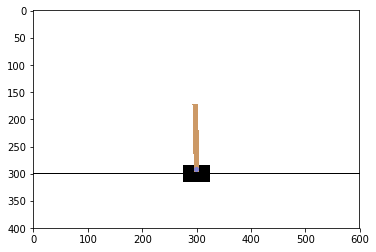

In [3]:
observation, reward, done, info = env.step(0)
frame = env.render(mode = 'rgb_array')
plt.imshow(frame)
plt.show()

### Random actions
With the function `env.action_space.sample()` you get a random action that's possible for this action space. Please take some time to figure out what kind of commands are possible, and what env.step does. 

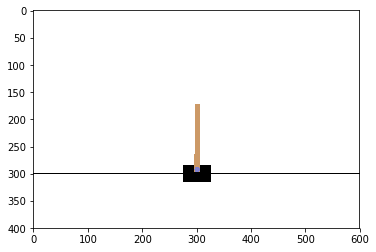

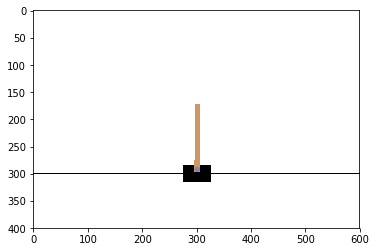

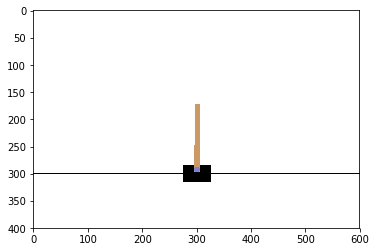

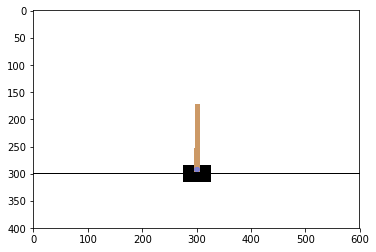

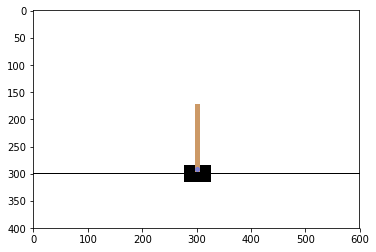

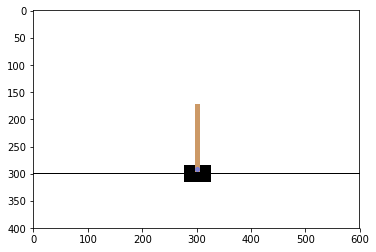

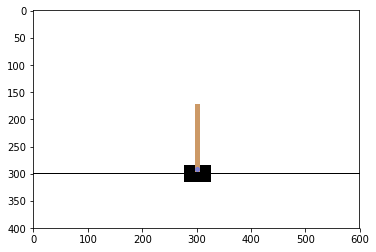

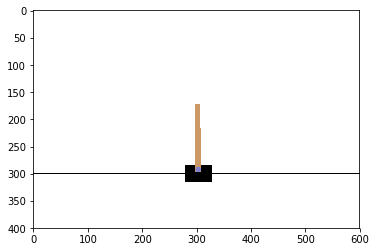

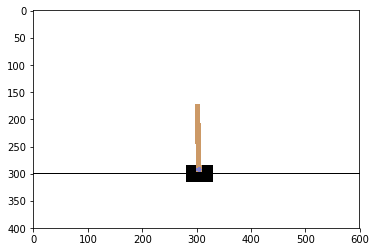

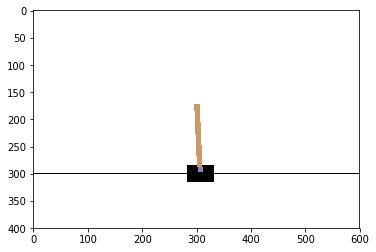

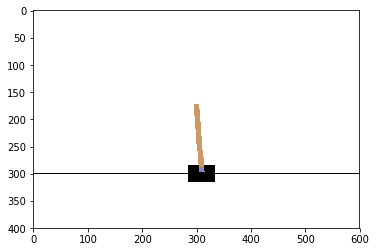

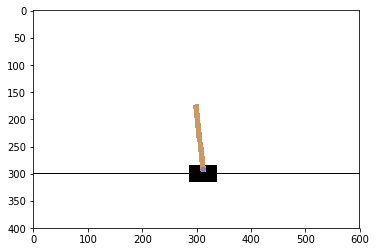

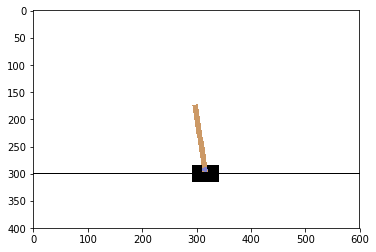

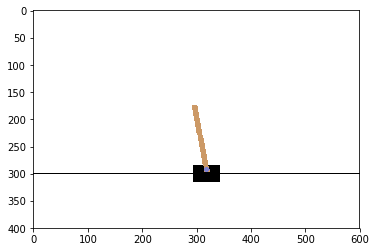

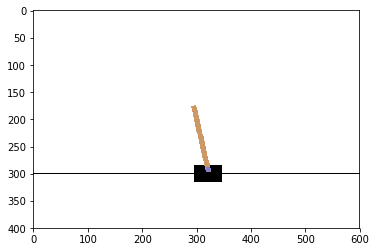

You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


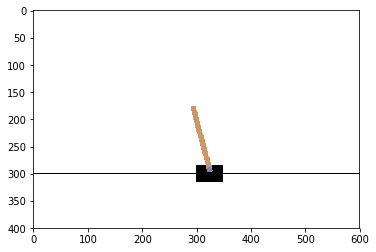

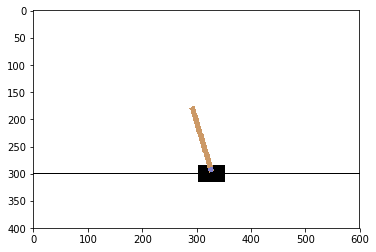

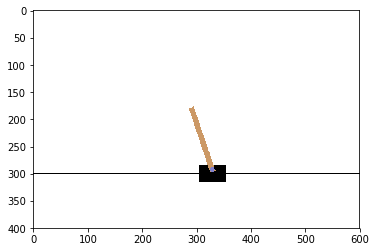

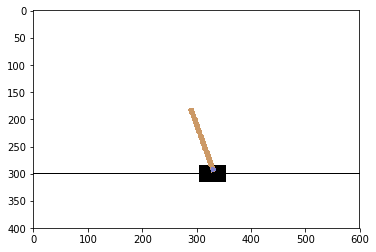

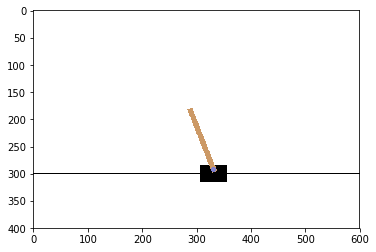

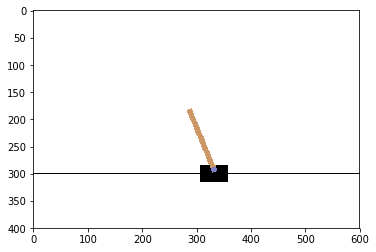

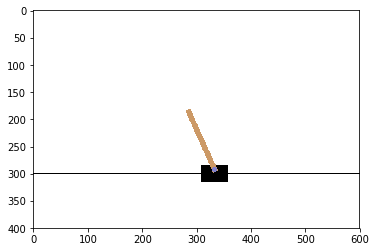

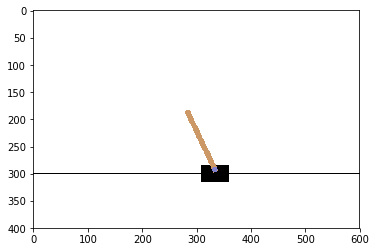

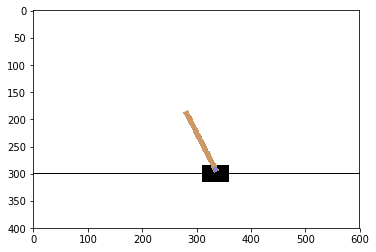

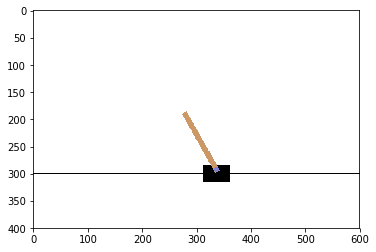

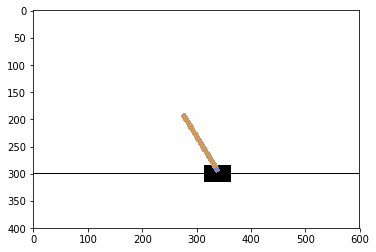

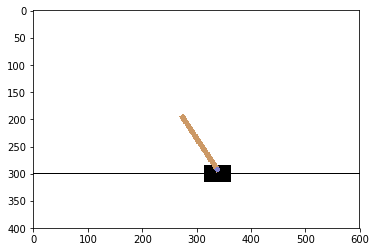

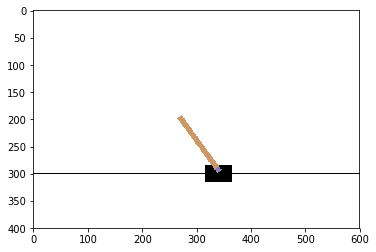

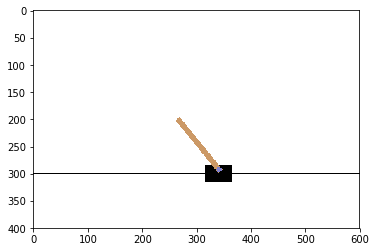

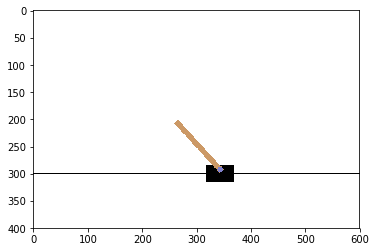

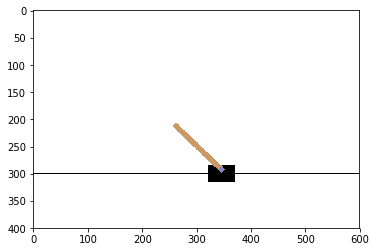

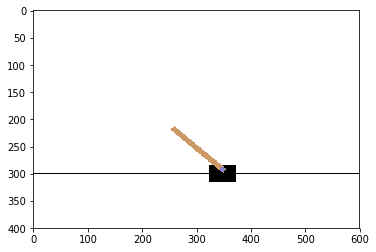

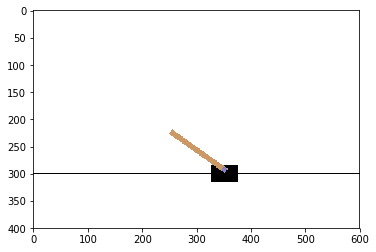

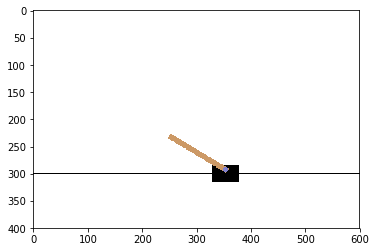

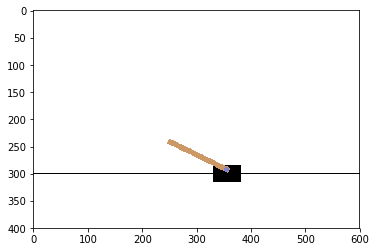

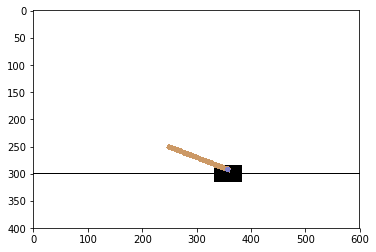

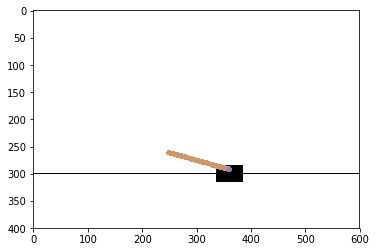

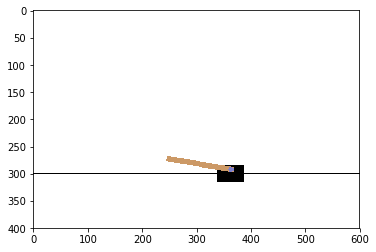

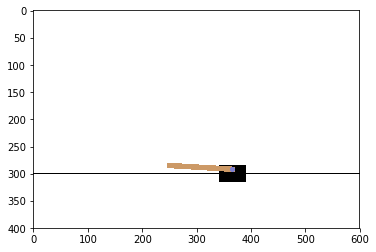

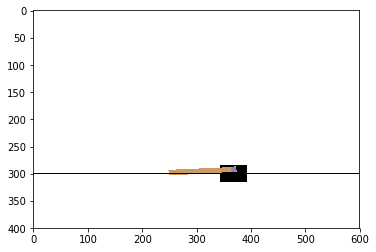

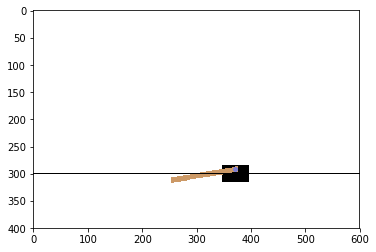

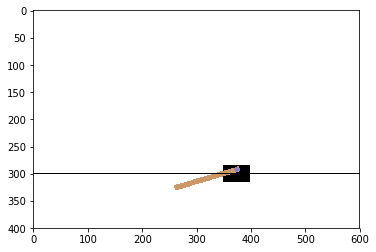

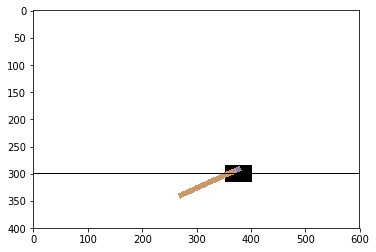

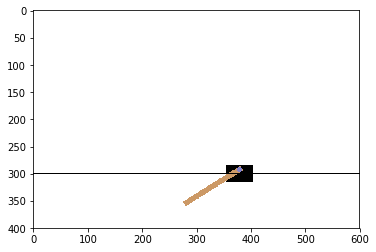

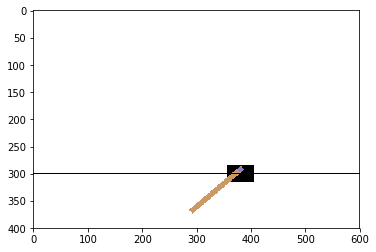

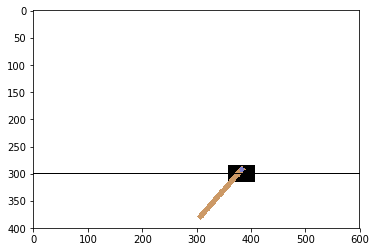

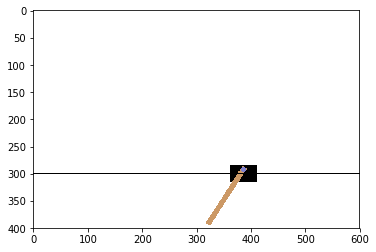

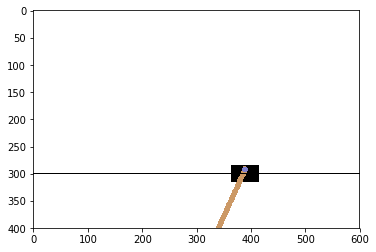

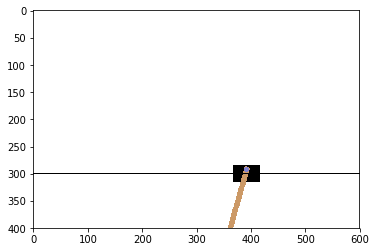

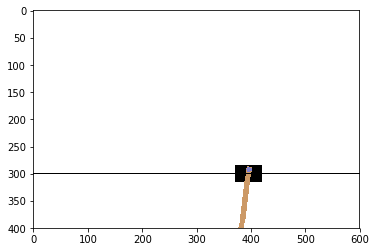

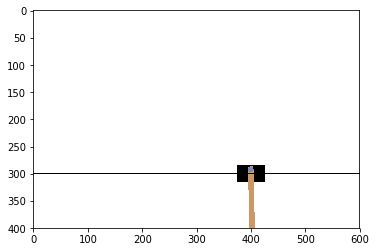

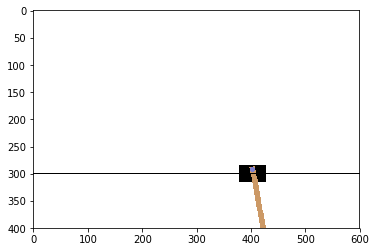

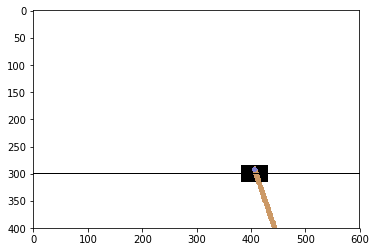

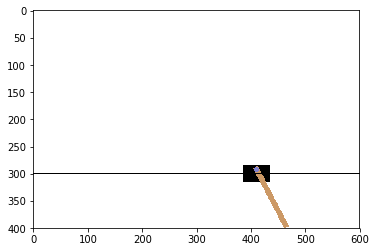

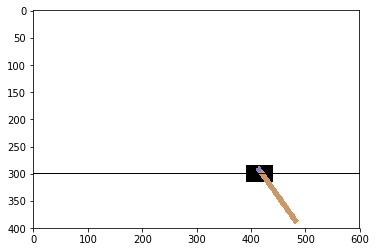

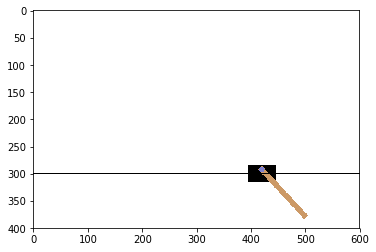

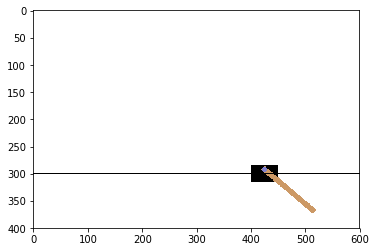

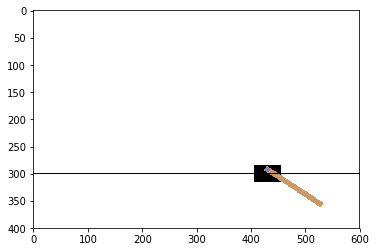

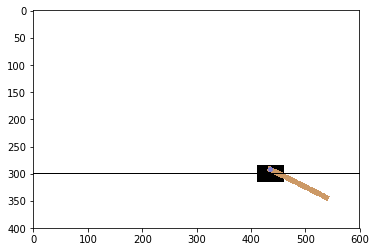

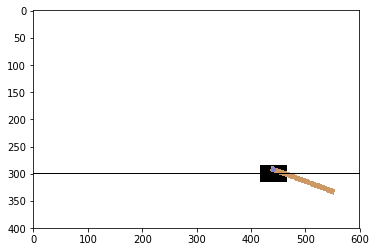

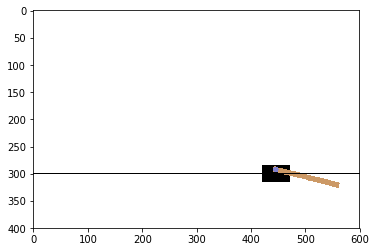

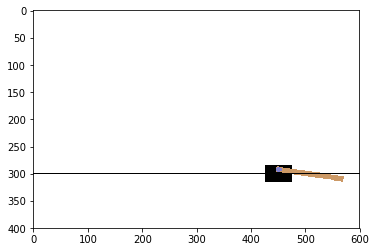

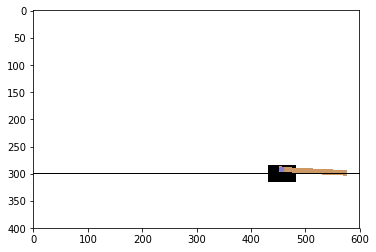

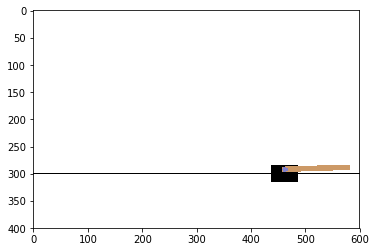

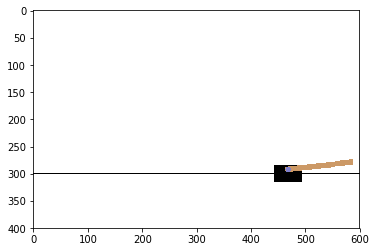

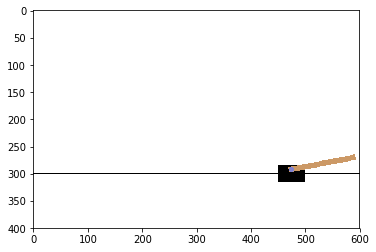

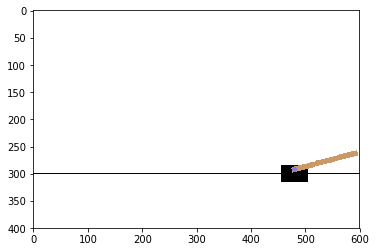

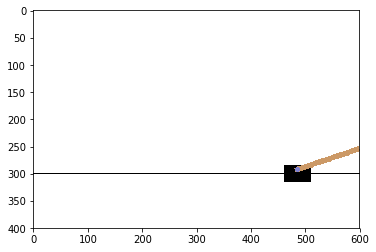

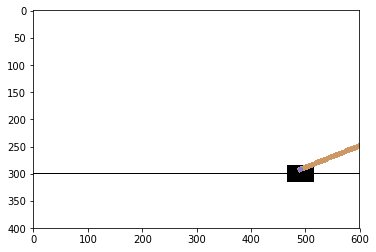

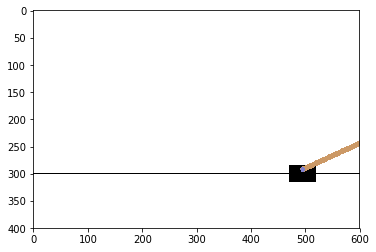

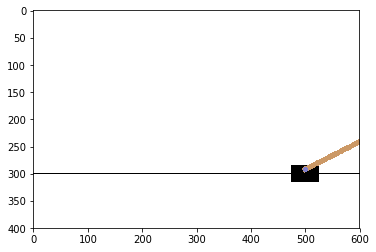

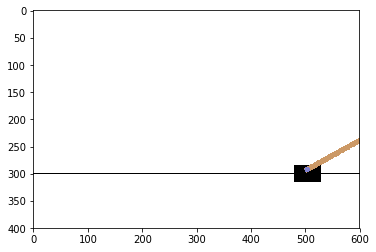

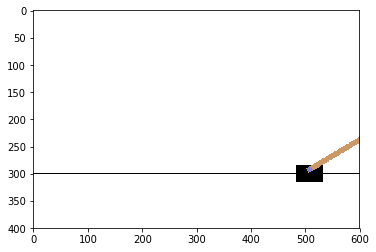

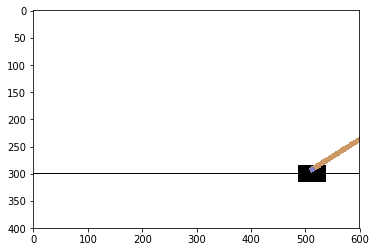

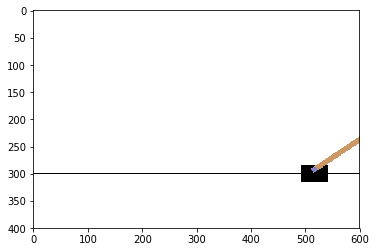

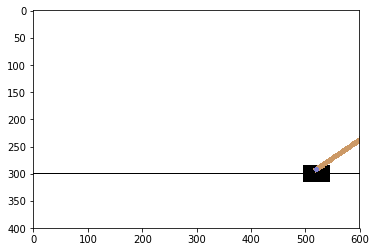

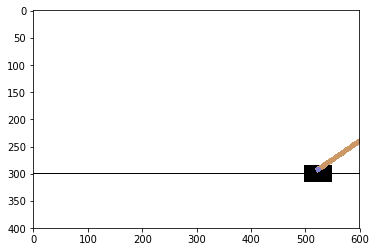

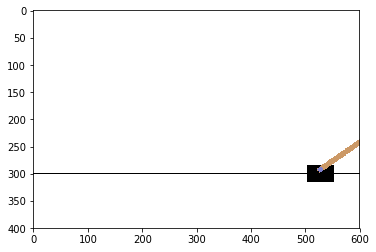

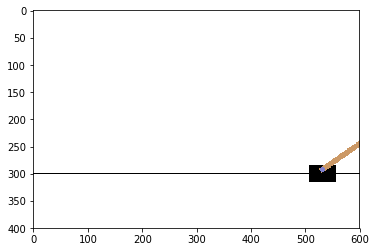

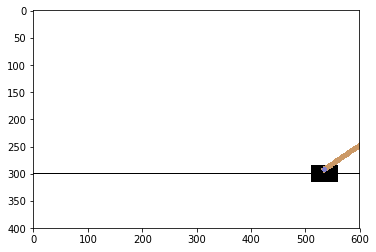

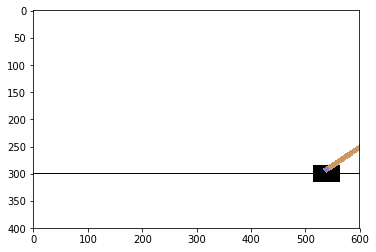

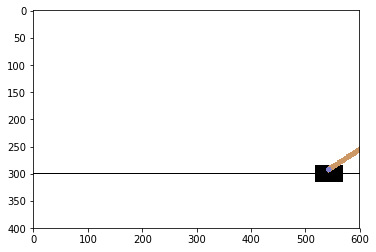

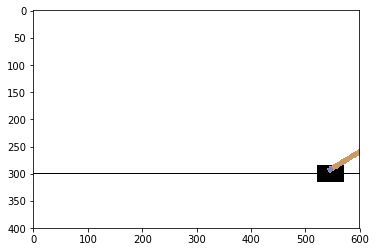

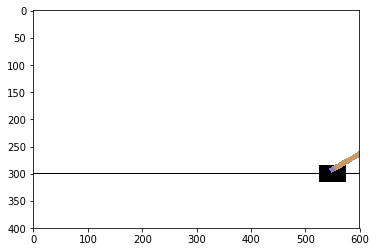

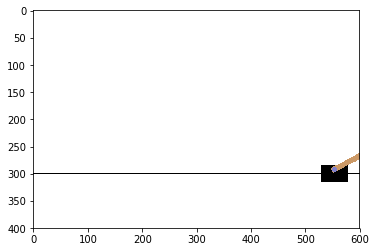

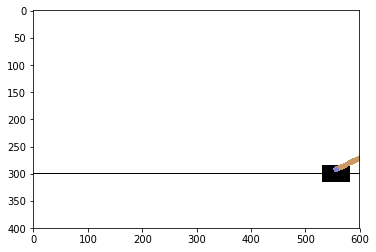

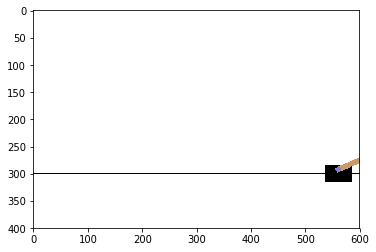

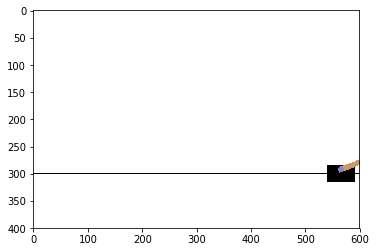

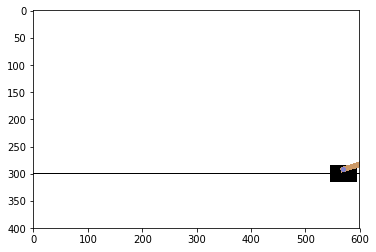

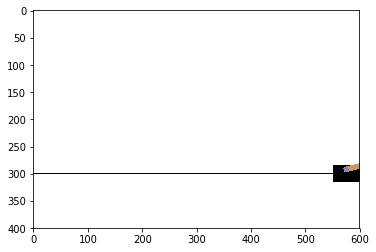

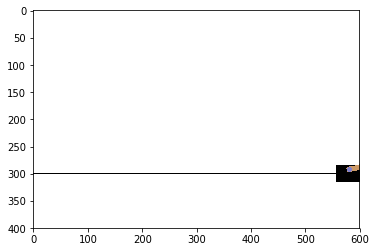

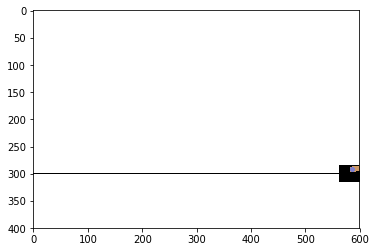

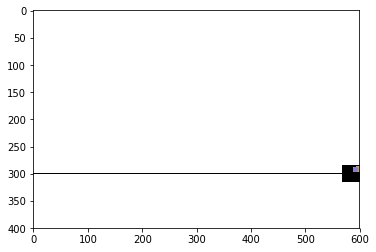

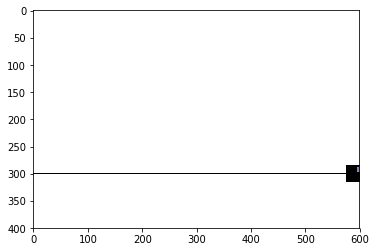

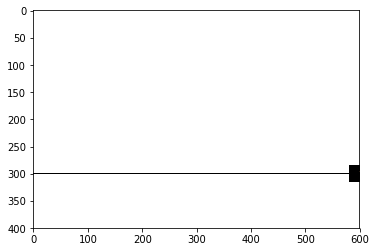

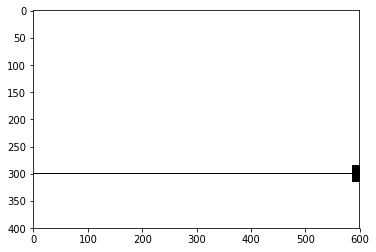

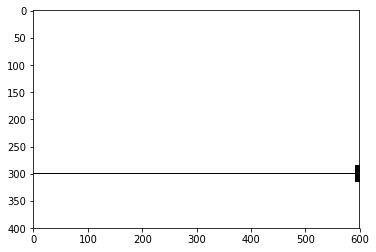

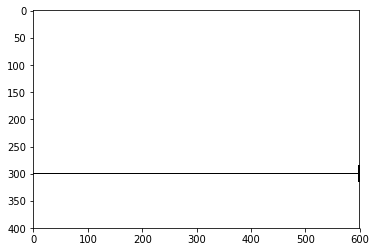

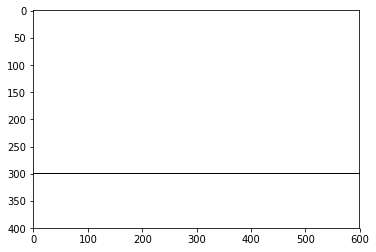

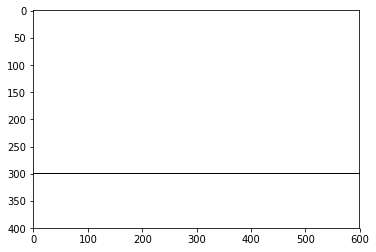

In [4]:
observation = env.reset()
for _ in range(100):
    frame = env.render(mode = 'rgb_array')
    plt.imshow(frame)
    plt.show()
    observation, reward, done, info = env.step(env.action_space.sample()) 

### Input to our algorithm
Let's explore the input we can use for our algorithm: 


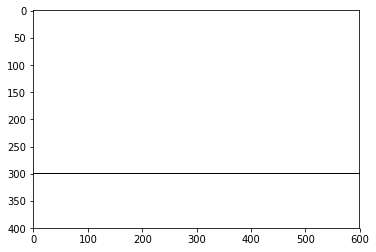

[ 2.75926101  2.57185965 -3.95011955  6.28070824]
0.0
True
{}


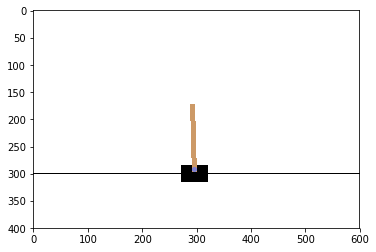

[-0.03037703 -0.16410413 -0.02987737  0.27314499]
1.0
False
{}


In [5]:
frame = env.render(mode = 'rgb_array')
plt.imshow(frame)
plt.show()

observation, reward, done, info = env.step(env.action_space.sample()) 
print(observation)
print(reward)
print(done)
print(info)

observation = env.reset()

frame = env.render(mode = 'rgb_array')
plt.imshow(frame)
plt.show()

observation, reward, done, info = env.step(env.action_space.sample()) 
print(observation)
print(reward)
print(done)
print(info)


##### Input
The input consists of the angle of the pole, turn velocity of the pole, the location of the base, and the movespeed of the base. Other environments have different inputs. Some environments (the Atari games) simply give you an image, other environments give a representation of the state. 

##### Reward
Reward is the reward our environment gives us each frame. For cartpole the reward is 1.0 while we managed to keep the stick in less than a small angle. After we reached this angle the reward will change to 0.0 while we did not reset the environment. 

Other environments give different rewards. Mountaincar for example gives a reward of 0.0 while we did not reach the top, and 1.0 once we reached it. Whenever you try a new environment make sure you know when your algorithm receives a reward as this is vital for learning something. 

##### Done
If this boolean is True it means you probably want to reset your network. In the case of cartpole it means the cart can't get anymore points: either by:
- failing to keep the pole at less than a certain angle
- failing to keep the base at less than a certain distance
- succeeding at this for more than 200 frames!

Other environments end when your lives are gone, others end after a certain amount of iterations.

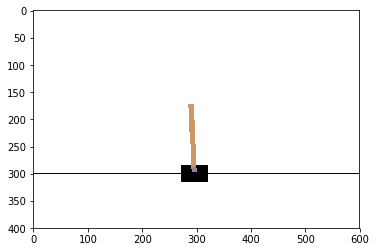

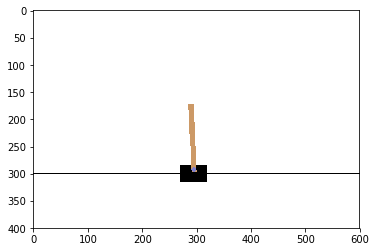

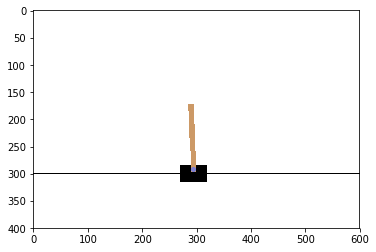

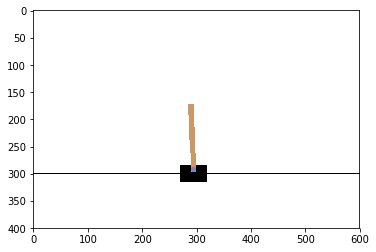

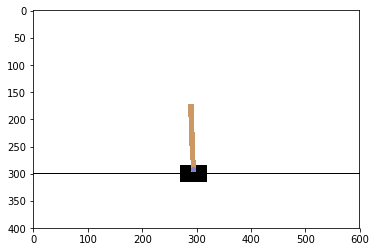

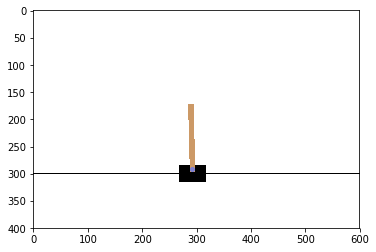

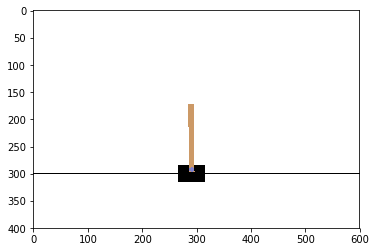

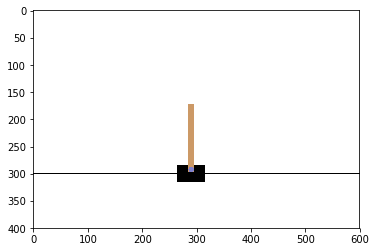

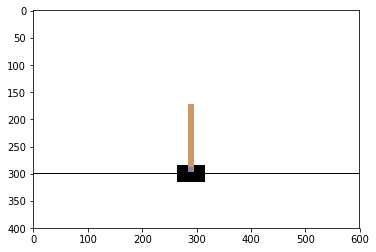

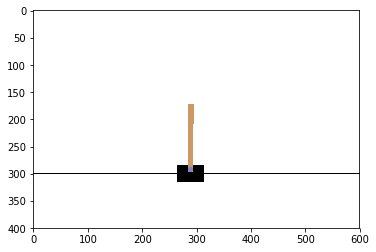

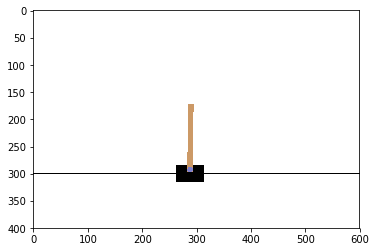

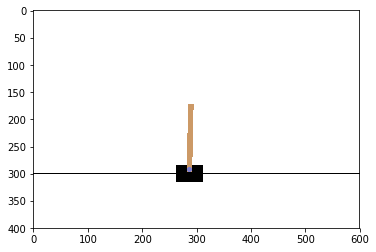

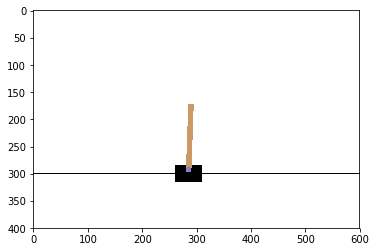

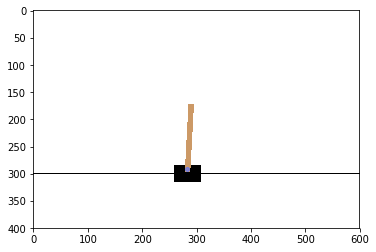

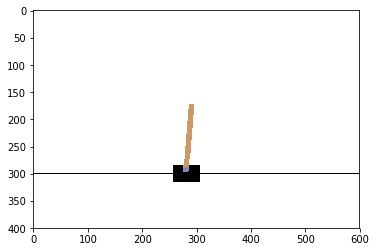

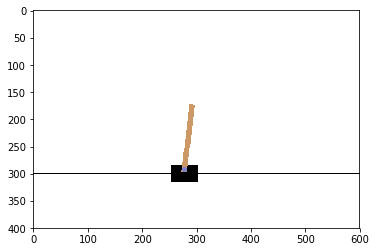

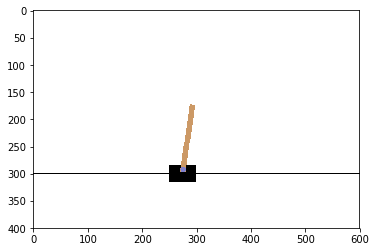

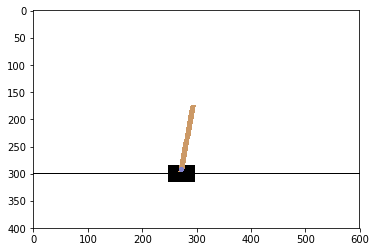

Done = true!


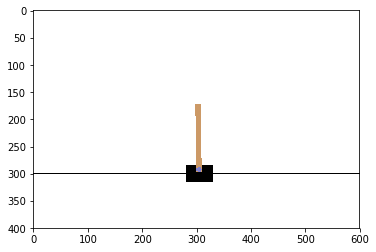

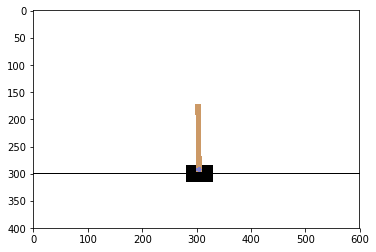

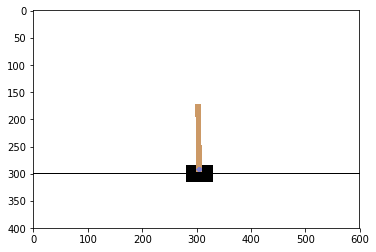

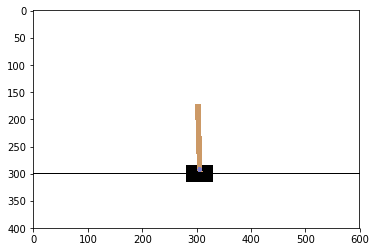

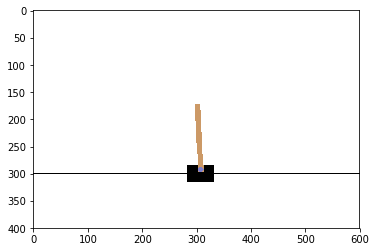

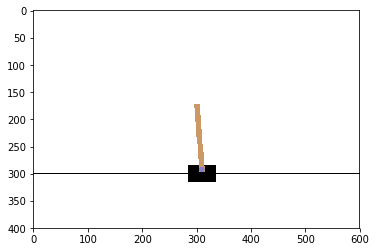

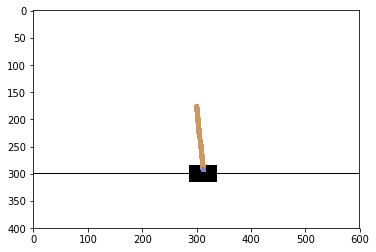

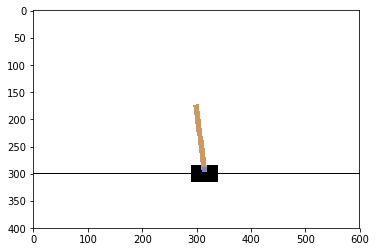

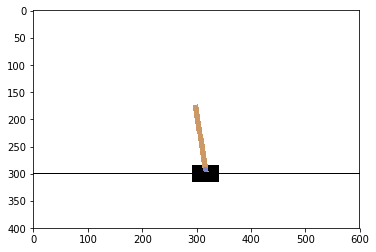

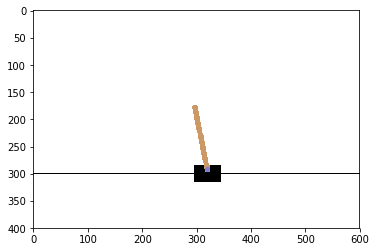

Done = true!


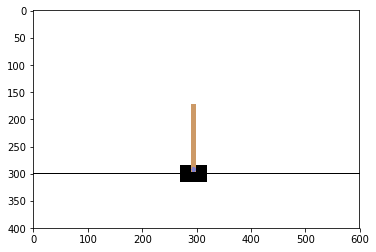

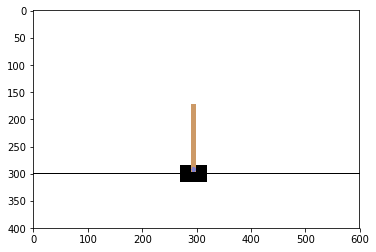

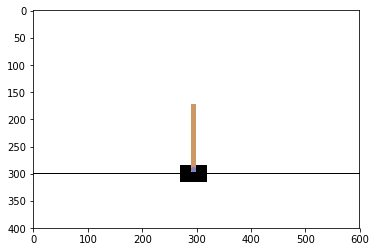

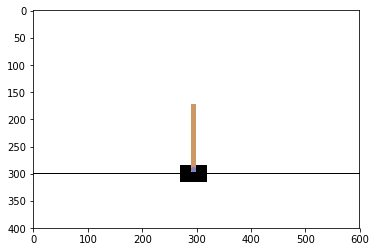

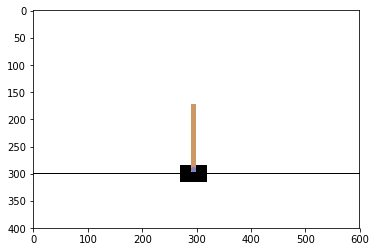

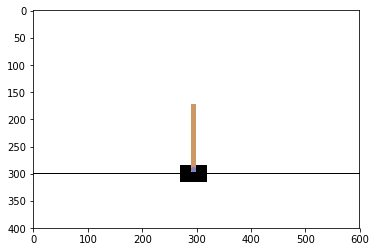

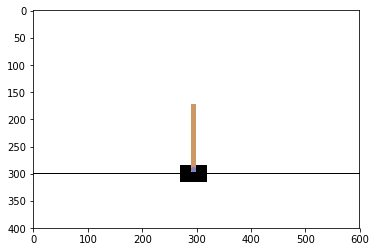

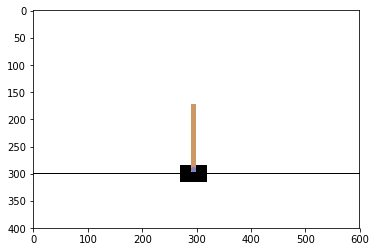

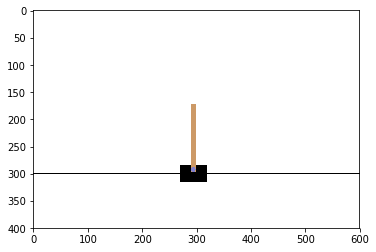

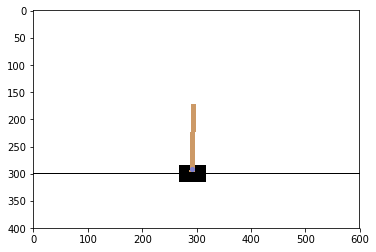

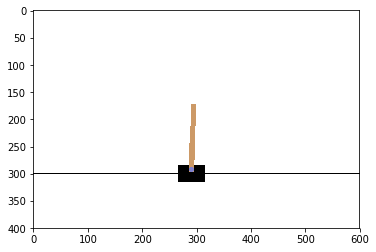

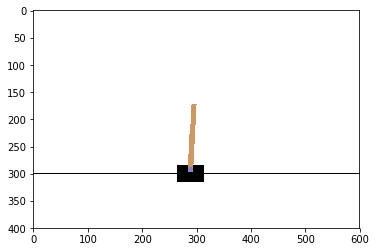

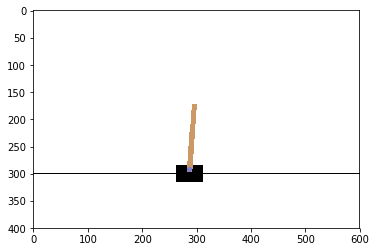

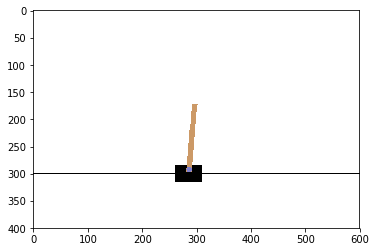

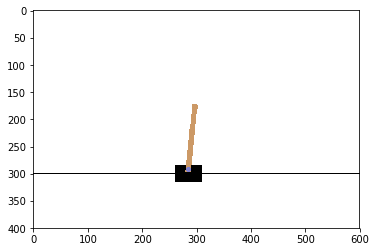

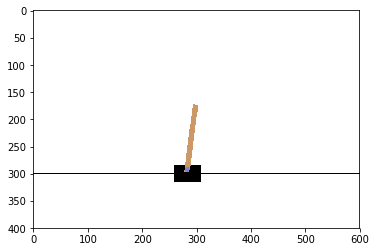

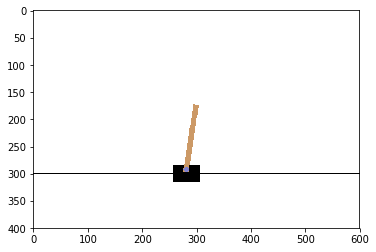

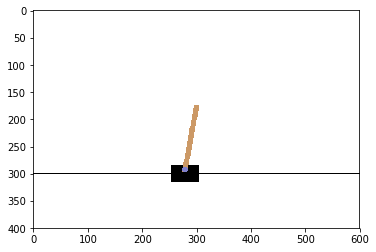

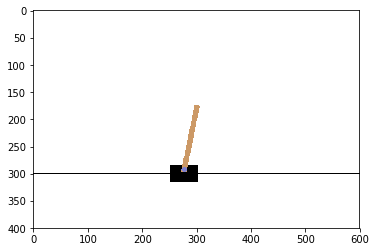

Done = true!


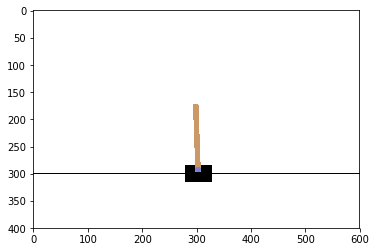

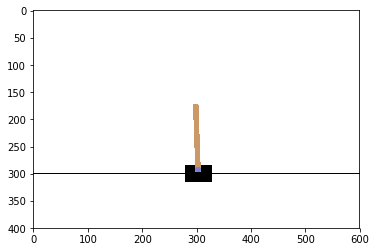

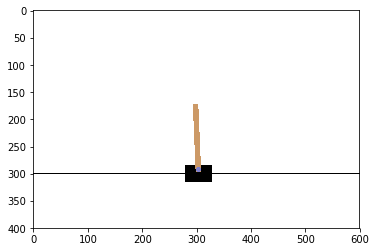

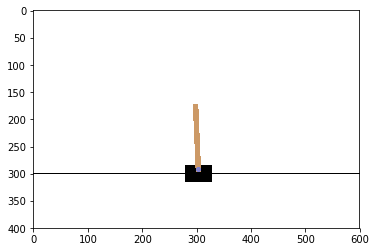

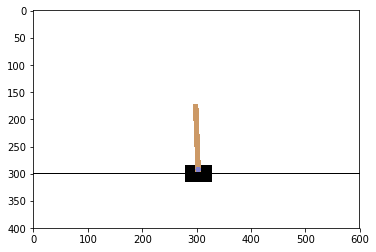

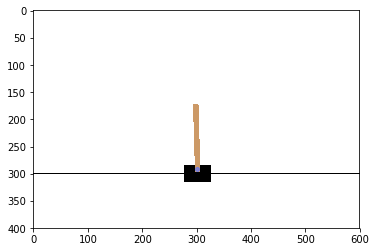

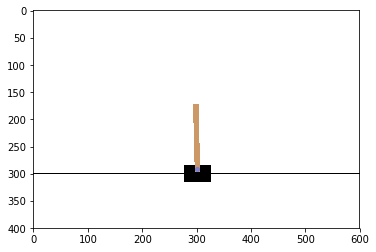

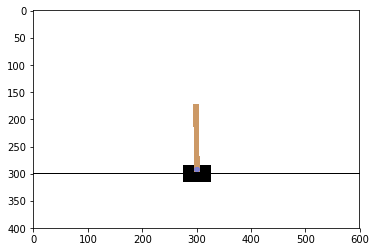

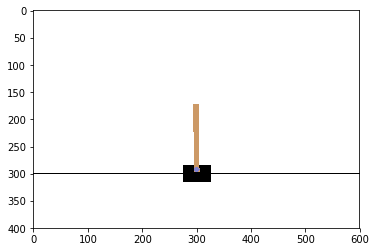

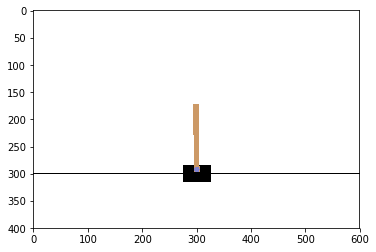

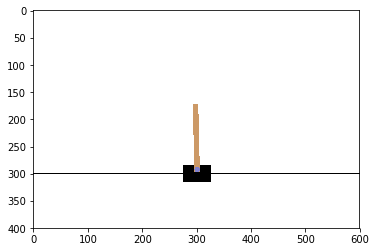

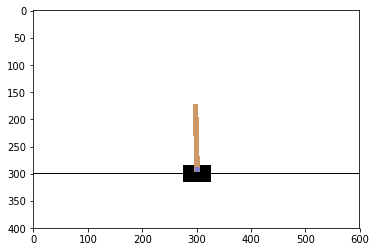

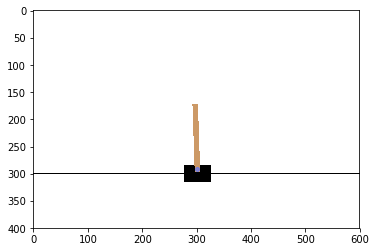

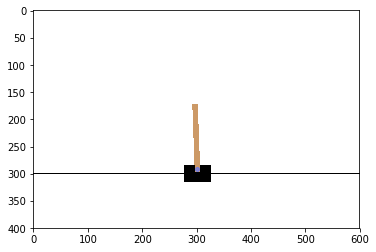

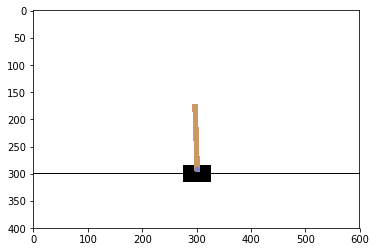

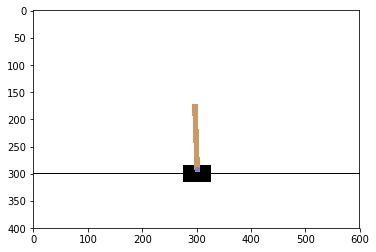

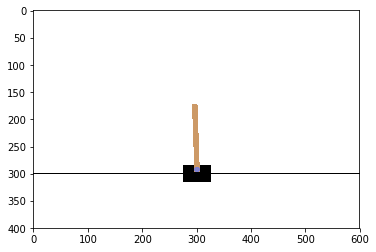

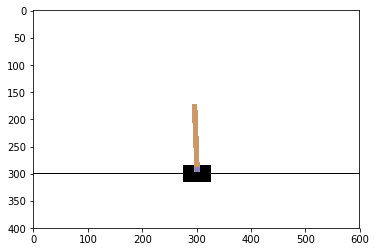

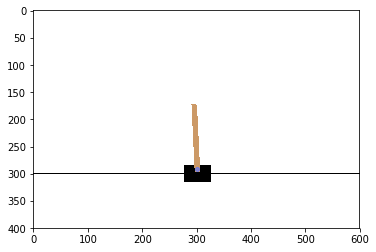

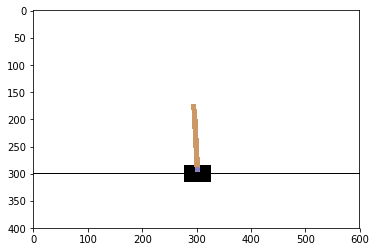

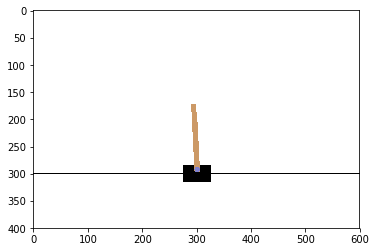

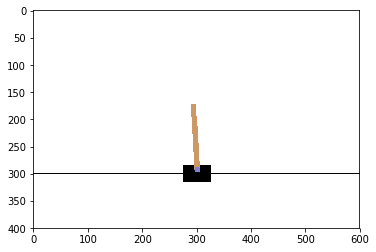

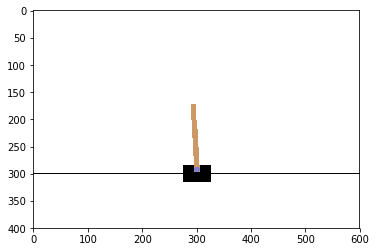

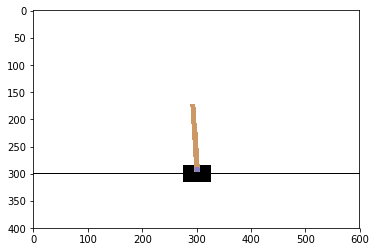

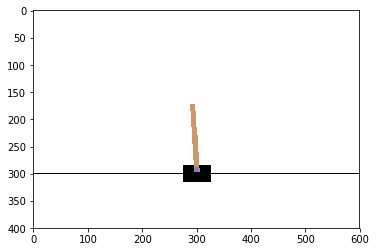

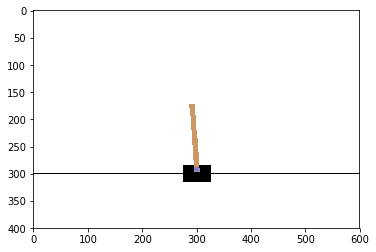

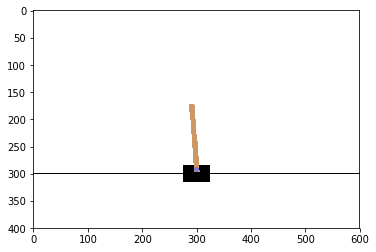

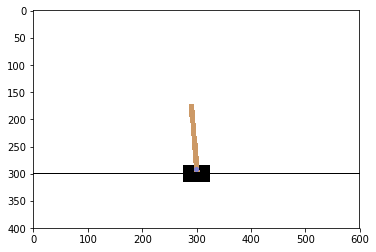

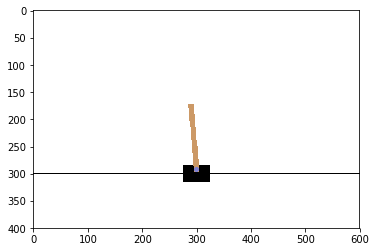

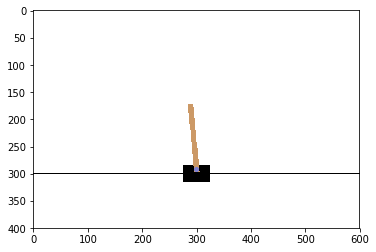

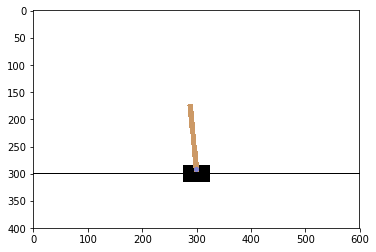

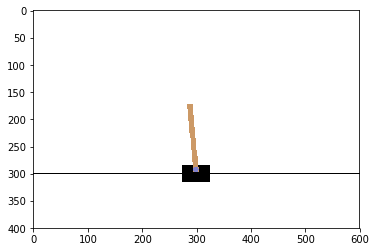

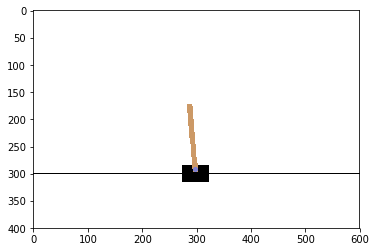

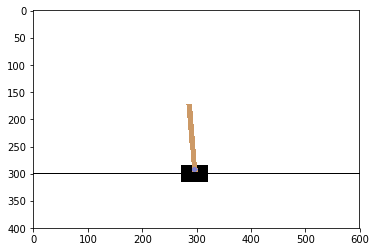

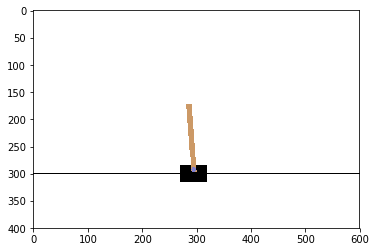

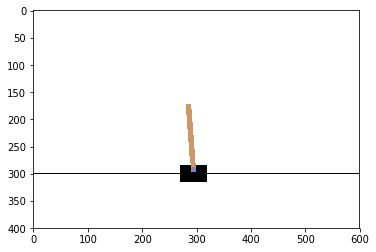

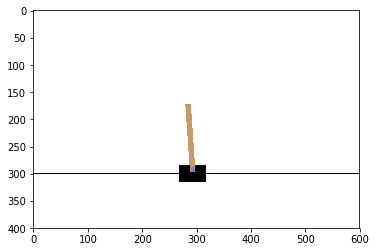

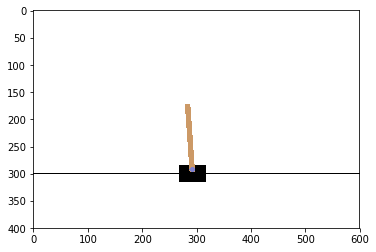

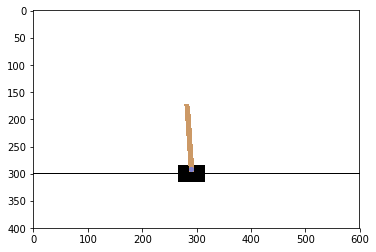

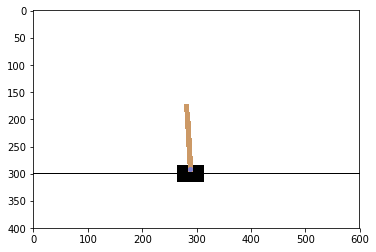

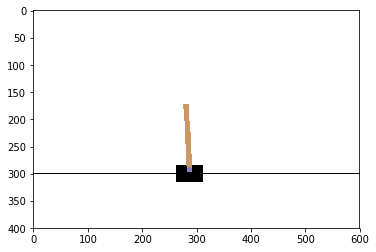

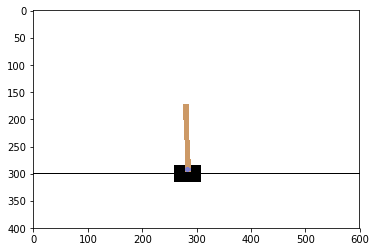

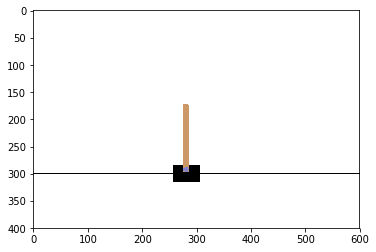

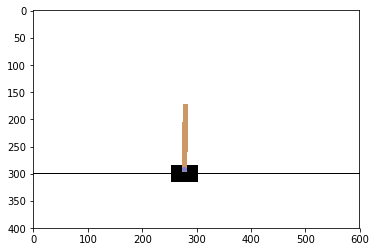

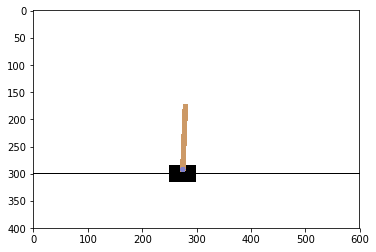

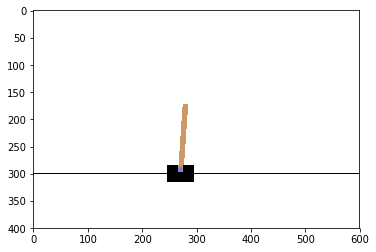

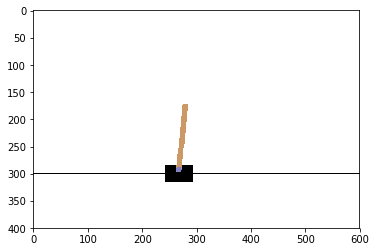

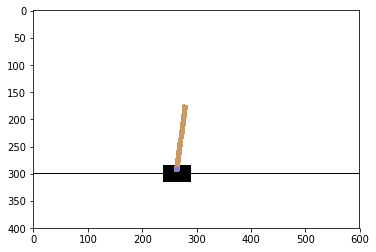

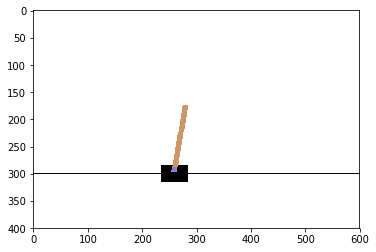

Done = true!


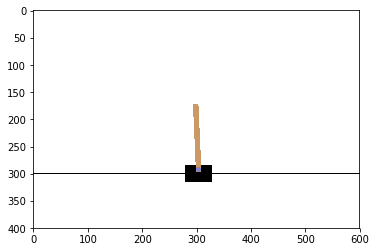

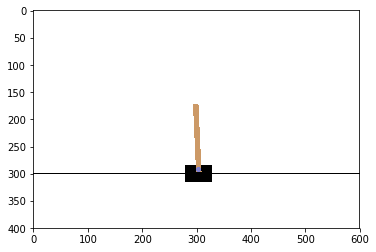

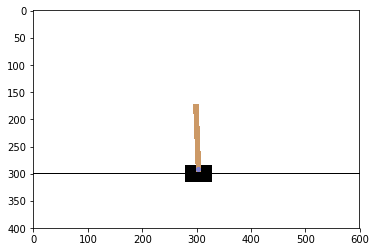

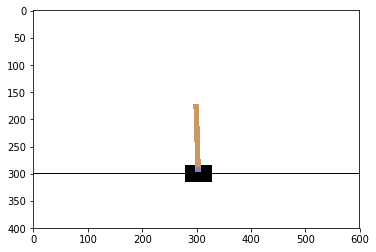

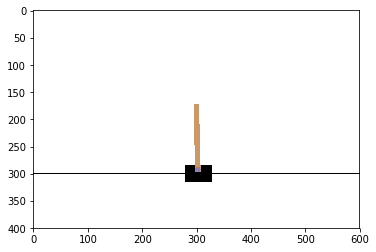

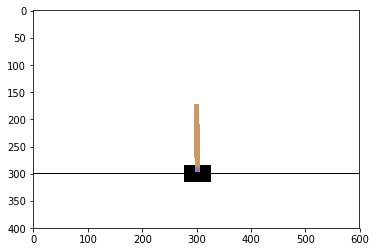

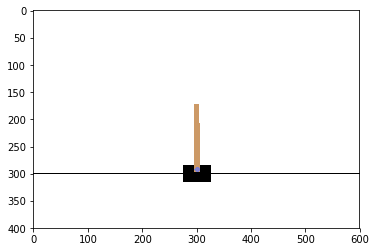

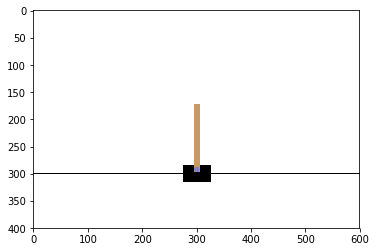

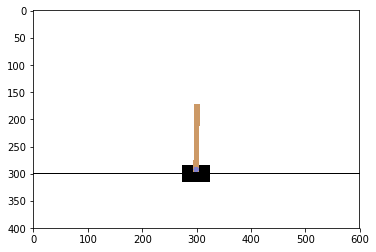

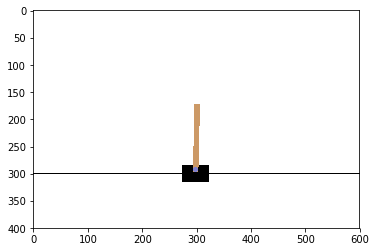

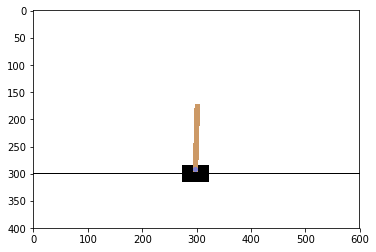

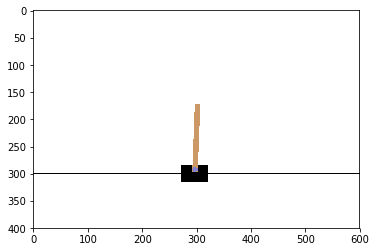

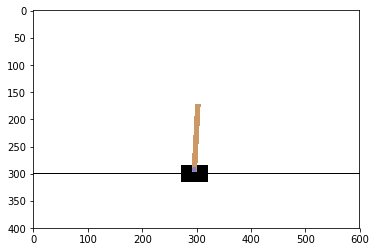

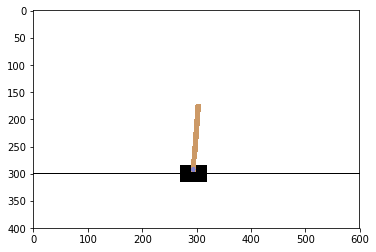

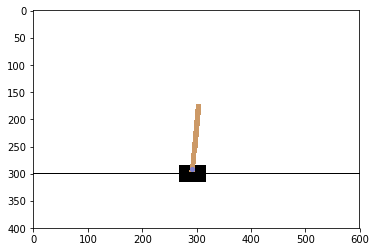

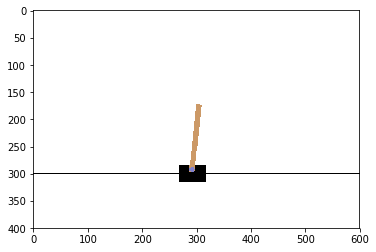

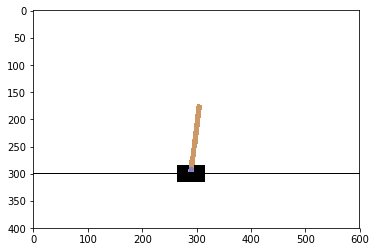

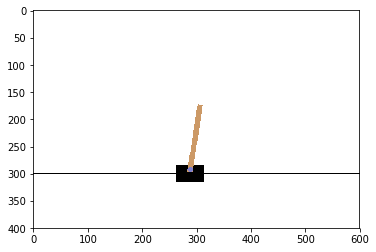

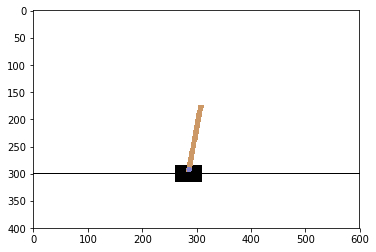

Done = true!


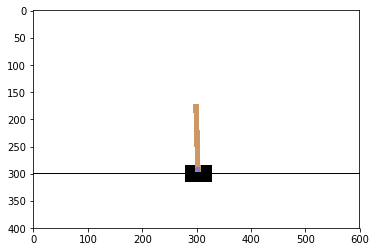

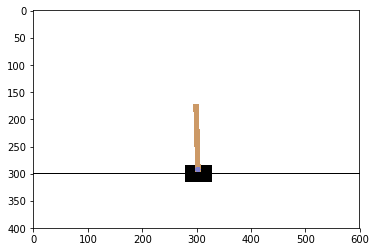

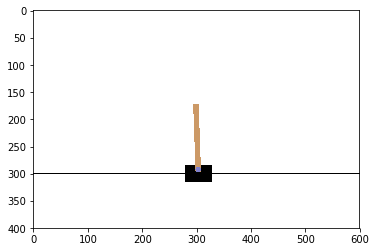

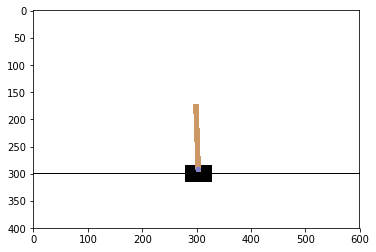

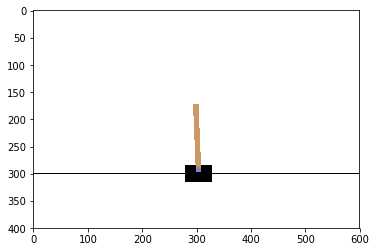

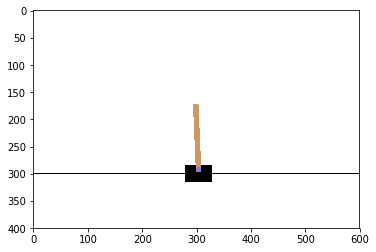

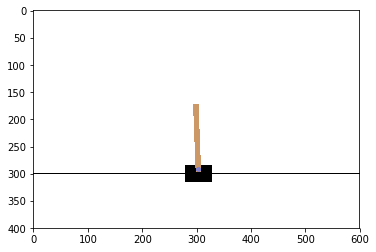

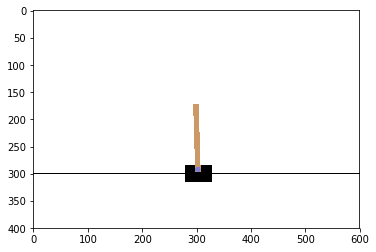

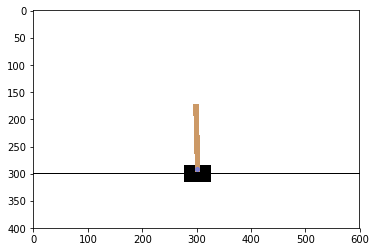

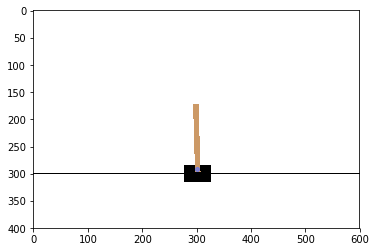

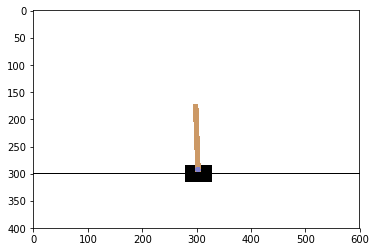

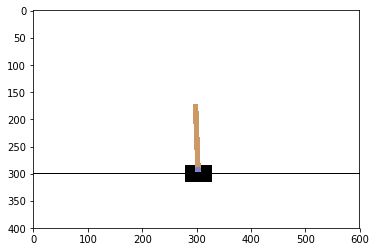

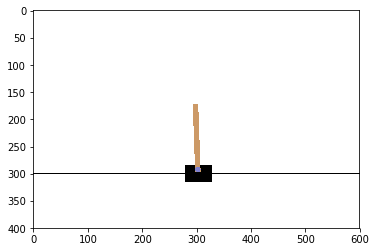

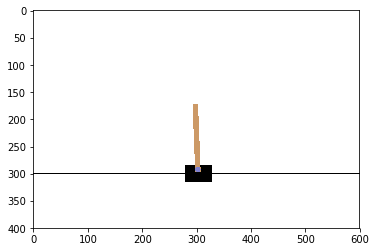

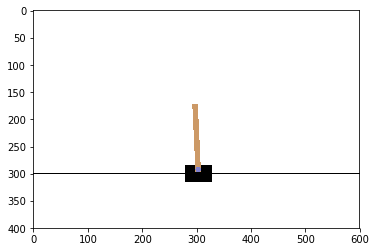

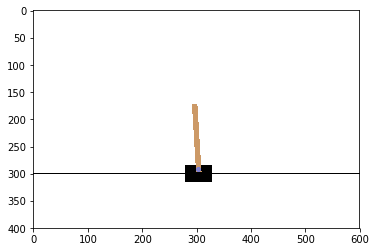

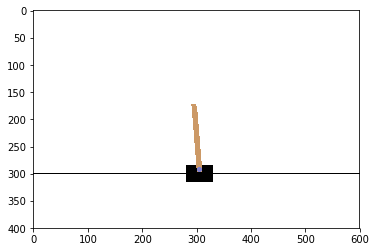

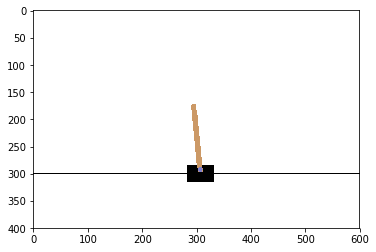

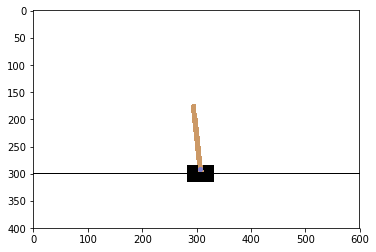

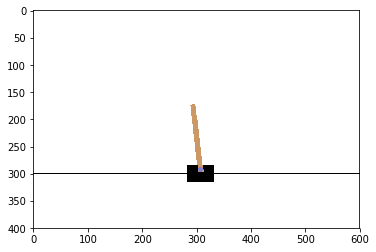

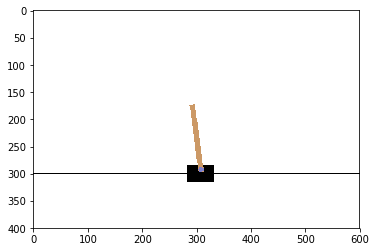

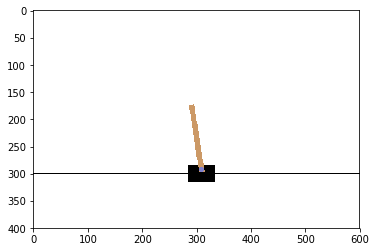

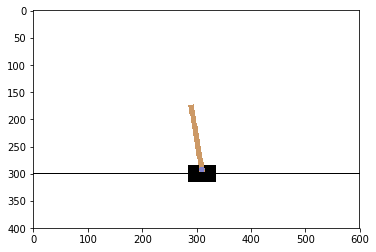

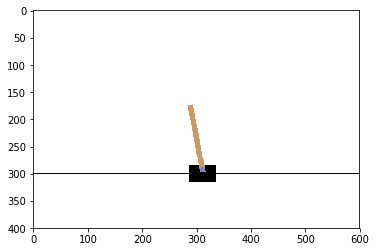

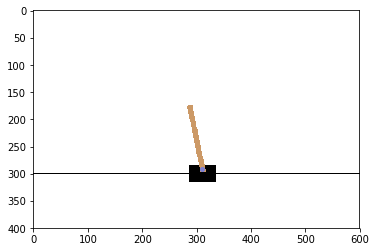

Done = true!


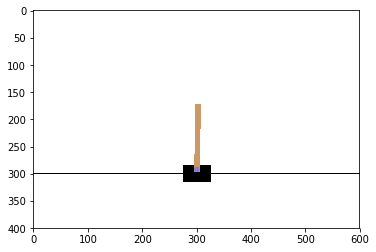

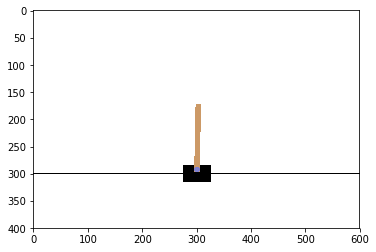

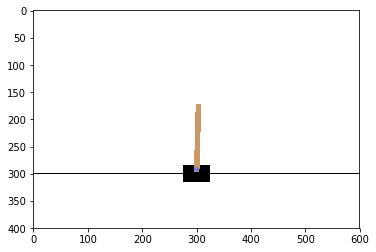

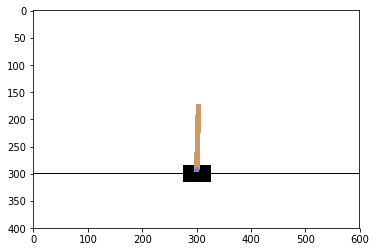

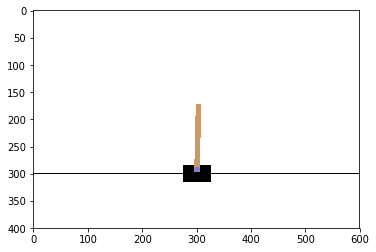

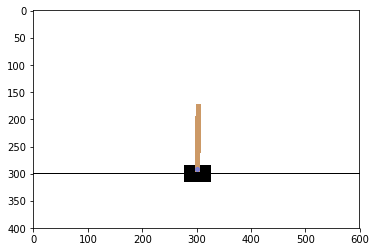

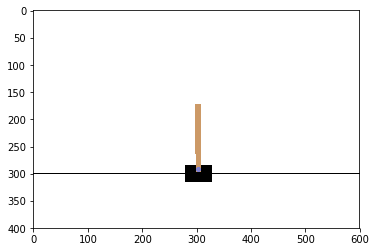

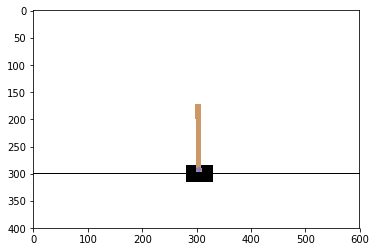

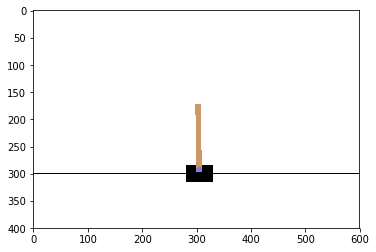

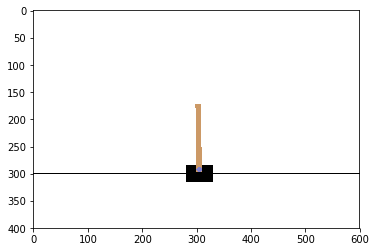

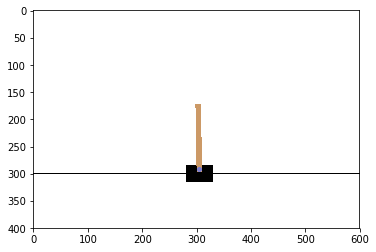

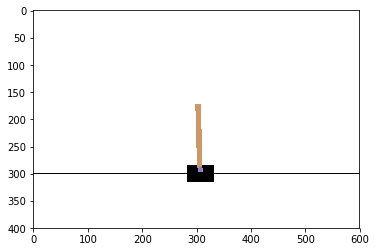

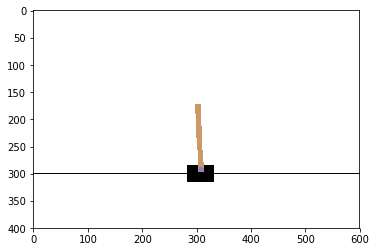

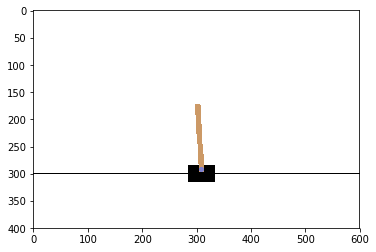

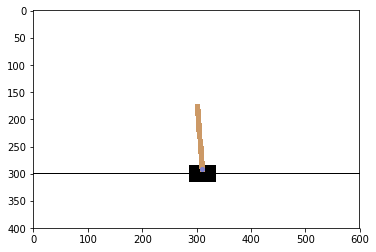

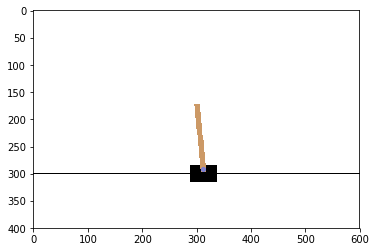

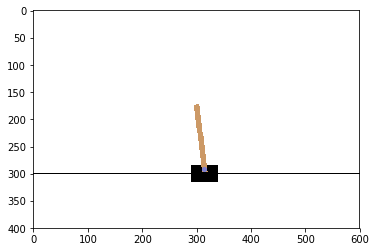

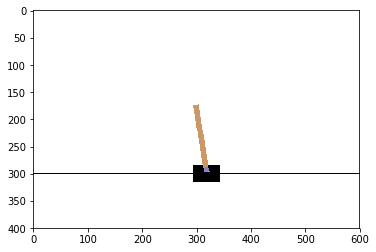

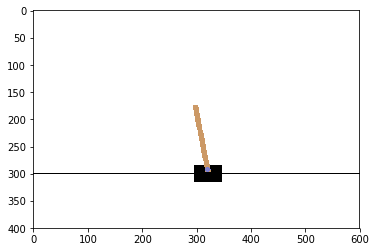

Done = true!


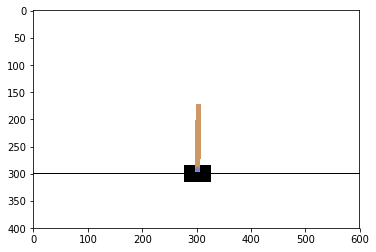

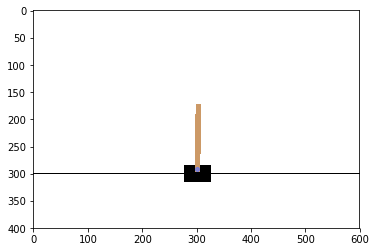

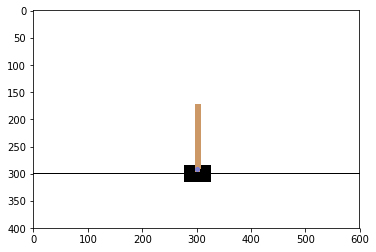

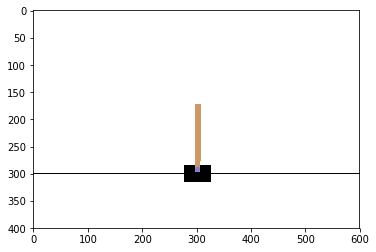

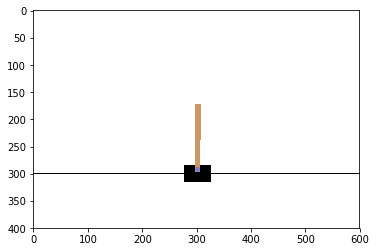

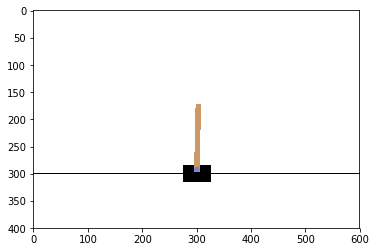

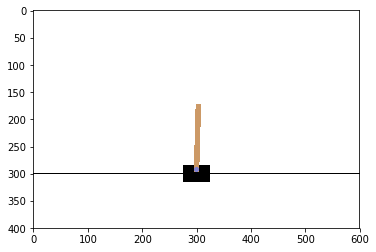

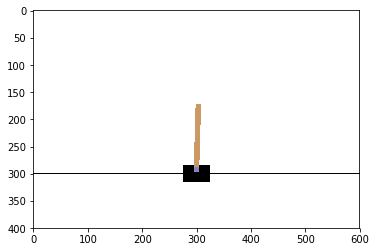

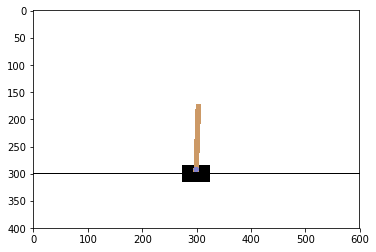

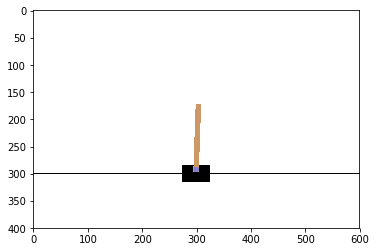

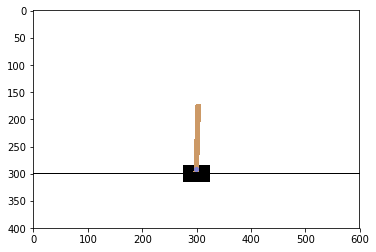

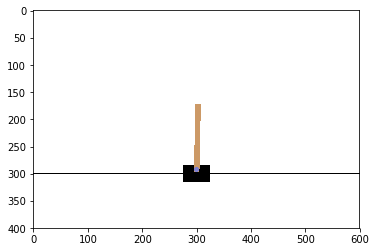

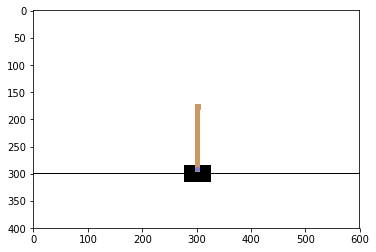

KeyboardInterrupt: 

In [6]:
observation = env.reset()
for _ in range(250):
    frame = env.render(mode = 'rgb_array')
    plt.imshow(frame)
    plt.show()
    observation, reward, done, info = env.step(env.action_space.sample()) 
    
    if done:
        print("Done = true!")
        observation = env.reset()

#### Playing yourself
Now you are able to play a pretty boring game with a text-interface...

In [7]:
# observation = env.reset()
# done = False
# while not done:
#     frame = env.render(mode = 'rgb_array')
#     plt.imshow(frame)
#     plt.show()
    
#     useraction = -1
#     while useraction < 0:
#         try:
#             useraction = int(input("Left (0) or right (1)?"))
#         except:
#             pass
        
        
#     observation, reward, done, info = env.step(useraction) 
# print("You are dead..")

## Video 2: Random search. Solving your first problem, and joining the leaderboard
http://kvfrans.com/simple-algoritms-for-solving-cartpole/



## Video 3: Reinforcement learning explained: approximating the value function
![reward fucntion](http://www.pinchofintelligence.com/wp-content/uploads/2017/07/rewardfunction.png)

In [3]:
testtrial = 0

In [4]:
tf.reset_default_graph()
networkstate = tf.placeholder(tf.float32, [None, 4], name="input")
networkaction = tf.placeholder(tf.int32, [None], name="actioninput")
networkreward = tf.placeholder(tf.float32,[None], name="groundtruth_reward")
action_onehot = tf.one_hot(networkaction, 2, name="actiononehot")

layer1 = tf.layers.dense(networkstate, 16, activation=tf.nn.relu, name="dense1")
layer2 = tf.layers.dense(layer1, 32, activation=tf.nn.relu, name="dense2")
layer3 = tf.layers.dense(layer2, 8, activation=tf.nn.relu, name="dense3")
predictedreward = tf.layers.dense(layer3, 2, name="dense4")


In [5]:
with tf.name_scope("lossdeterminer"):
    qreward = tf.reduce_sum(tf.multiply(predictedreward, action_onehot), reduction_indices = 1)
    loss = tf.reduce_mean(tf.square(networkreward - qreward))

tf.summary.scalar('loss', loss)
optimizer = tf.train.AdamOptimizer().minimize(loss)
#optimizer = tf.train.RMSPropOptimizer(0.0001).minimize(loss)
merged_summary = tf.summary.merge_all()


In [6]:
sess = tf.InteractiveSession()
summary_writer = tf.summary.FileWriter('graphs/dqn/normal/'+str(testtrial),sess.graph)
testtrial +=1
sess.run(tf.global_variables_initializer())


### Setting hyperparameters

In [12]:
BATCH_SIZE = 32
GAMMA = 0.9
MAX_LEN_REPLAY_MEMORY = 10000
FRAMES_TO_PLAY = 50001
MIN_FRAMES_FOR_LEARNING = 1000

### Training

In [9]:
def learn(replay_memory):
      ### Learn once we have enough frames to start learning
    if len(replay_memory) > MIN_FRAMES_FOR_LEARNING: 
        experiences = random.sample(replay_memory, BATCH_SIZE)
        totrain = [] # (state, action, delayed_reward)
        
        ### Calculate the predicted reward
        nextstates = [var[4] for var in experiences]
        pred_reward = sess.run(predictedreward, feed_dict={networkstate:nextstates})
        
        ### Set the "ground truth": the value our network has to predict:
        for index in range(BATCH_SIZE):
            state, action, reward, terminalstate, newstate = experiences[index]
            predicted_reward = max(pred_reward[index])
            
            if terminalstate:
                delayedreward = reward
            else:
                delayedreward = reward + GAMMA*predicted_reward
            totrain.append((state, action, delayedreward))
            
        ### Feed the train batch to the algorithm 
        states = [var[0] for var in totrain]
        actions = [var[1] for var in totrain]
        rewards = [var[2] for var in totrain]
        _, l, summary = sess.run([optimizer, loss, merged_summary], feed_dict={networkstate:states, networkaction: actions, networkreward: rewards})


        ### If our memory is too big: remove the first element
        if len(replay_memory) > MAX_LEN_REPLAY_MEMORY:
                replay_memory = replay_memory[1:]

        ### Show the progress 
        summary_writer.add_summary(summary, i_epoch)

  

You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


### Running this in our environment

In [ ]:
replay_memory = [] # (state, action, reward, terminalstate, state_t+1)

for i_epoch in range(FRAMES_TO_PLAY):
    
    ### Select an action and perform this
    action = env.action_space.sample() 
    newobservation, reward, terminal, info = env.step(action)

    ### I prefer that my agent gets 0 reward if it dies
    if terminal: 
        reward = 0
        
    ### Add the observation to our replay memory
    replay_memory.append((observation, action, reward, terminal, newobservation))
    
    ### Reset the environment if the agent died
    if terminal: 
        newobservation = env.reset()
    observation = newobservation
    
    learn(replay_memory)
    

### Now test this

RUN pip install git+https://github.com/jakevdp/JSAnimation.git

Use imagemagick, 



In [13]:
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

def display_frames_as_gif(frames, filename_gif = None):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    if filename_gif: 
        anim.save(filename_gif, writer = 'imagemagick', fps=20)
    display(display_animation(anim, default_mode='loop'))


Frames: 46



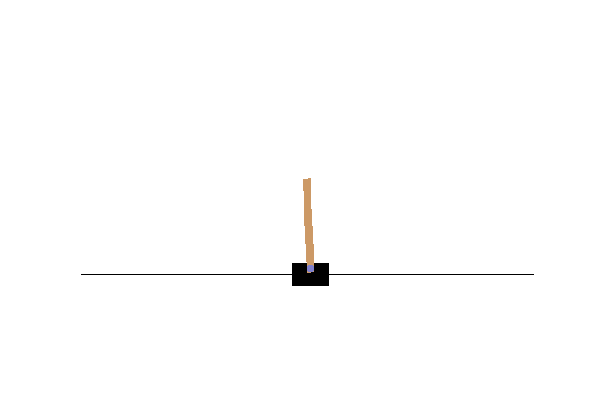
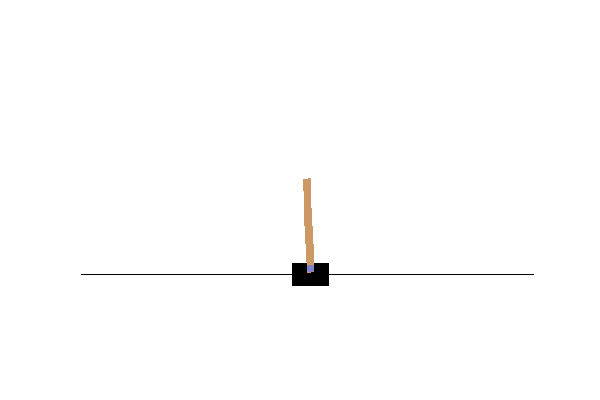
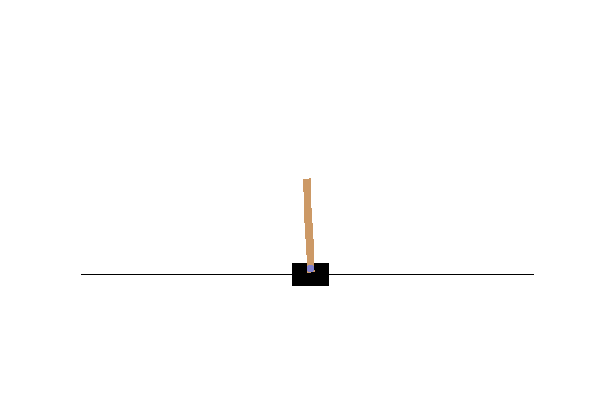
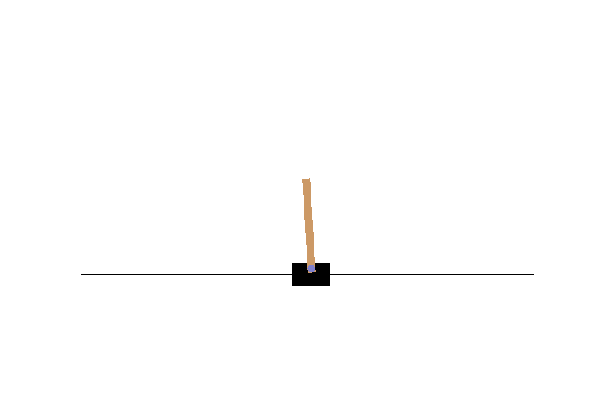
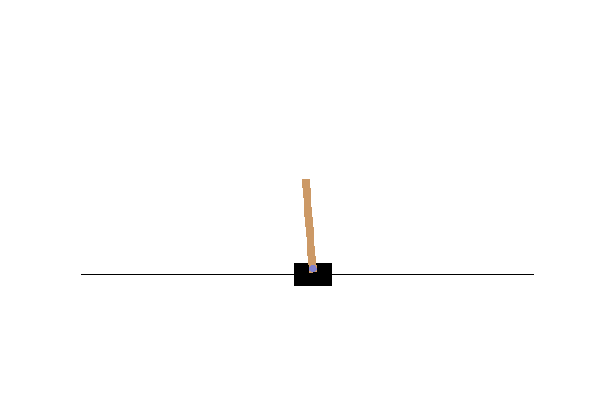
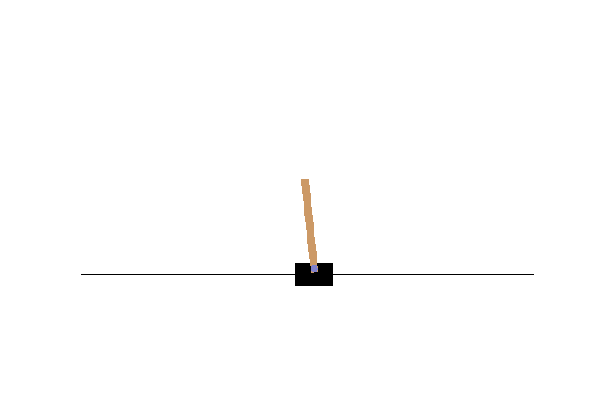
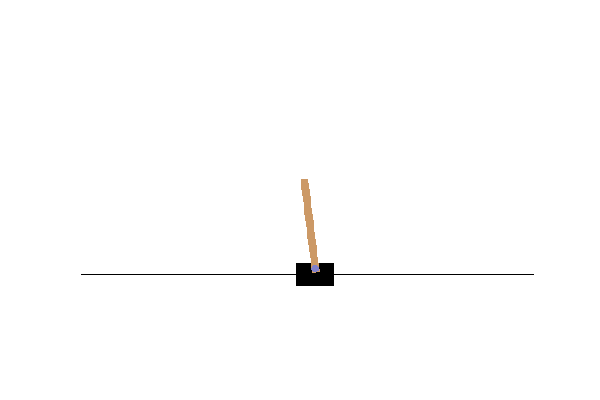
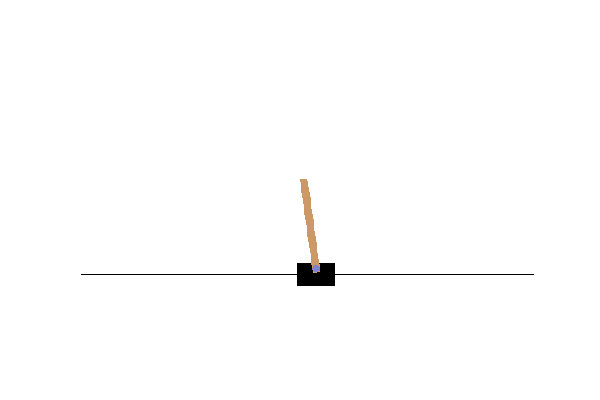
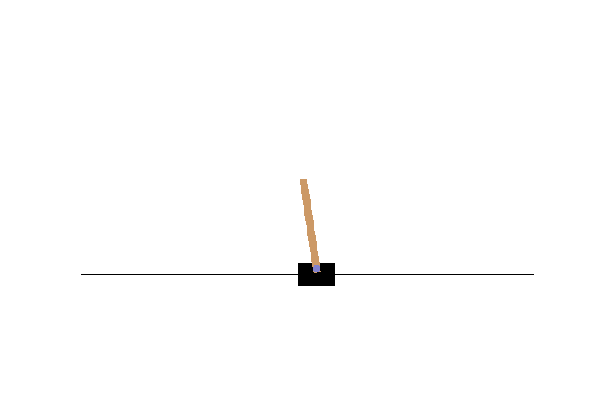
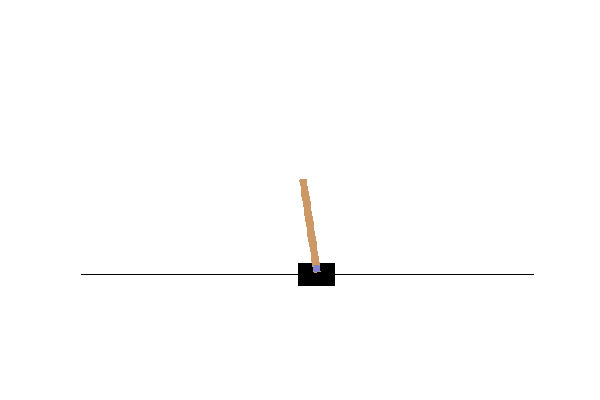
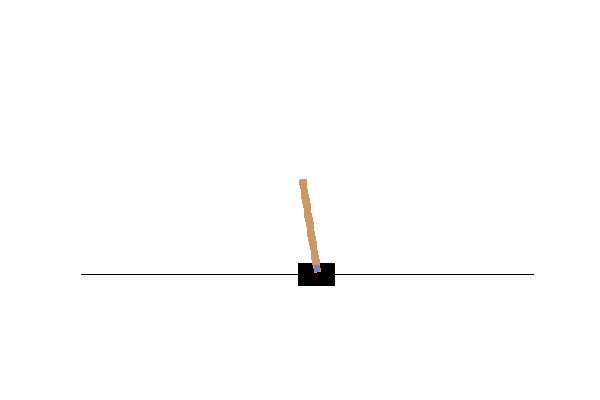
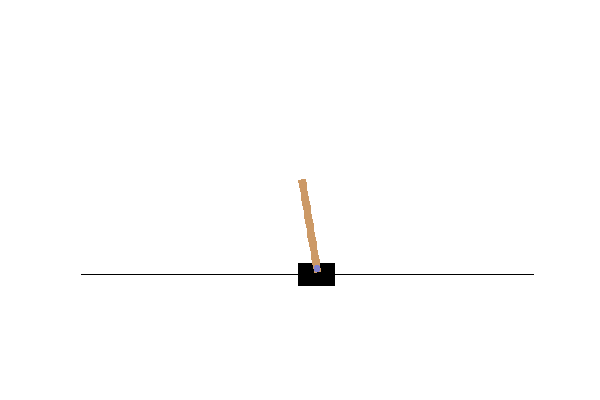
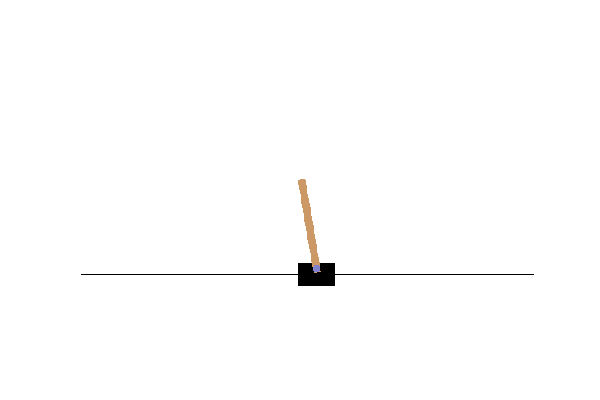
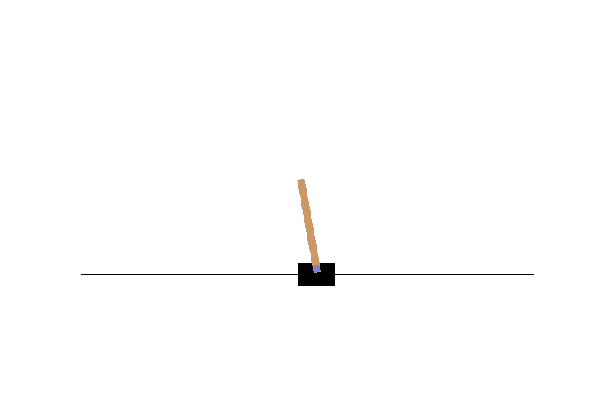
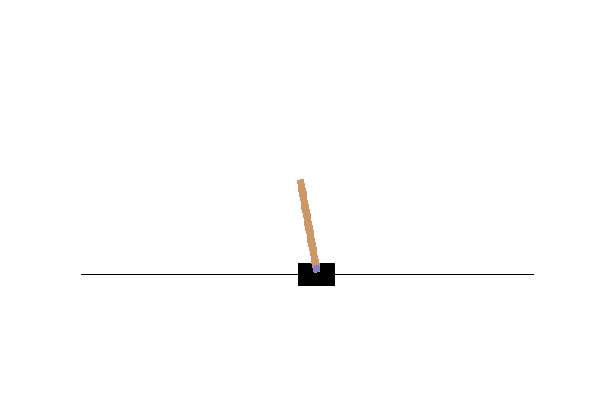
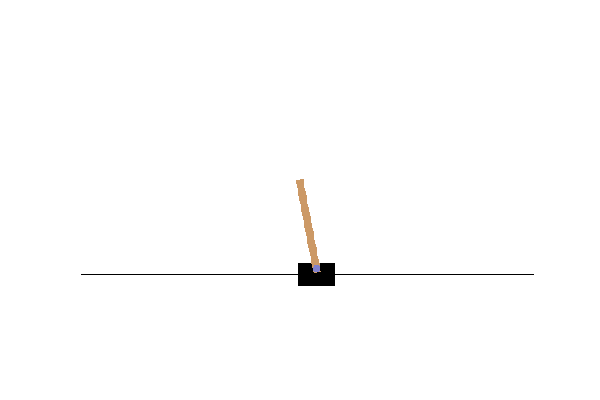
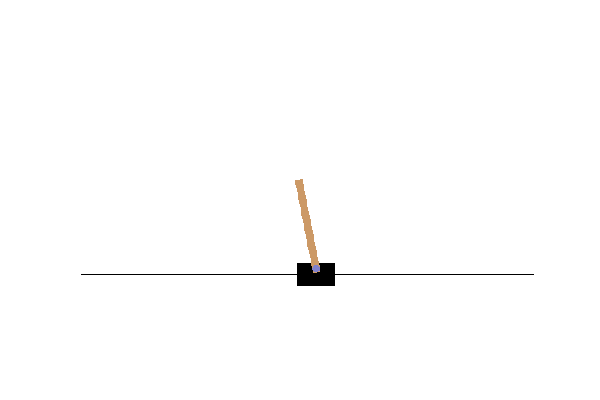
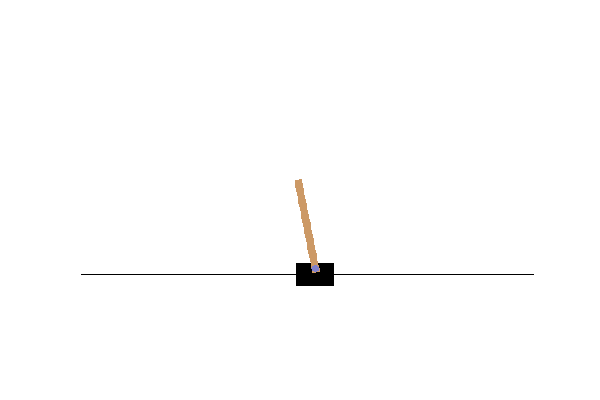
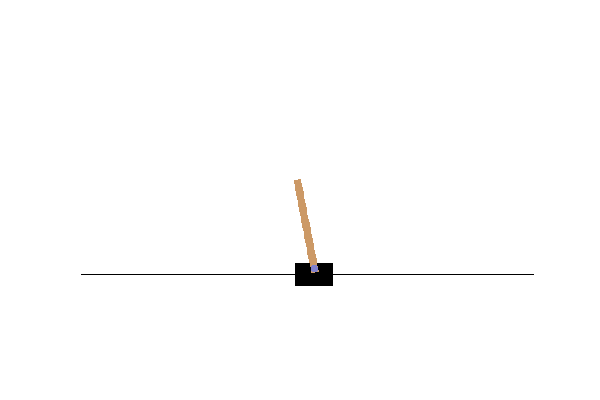
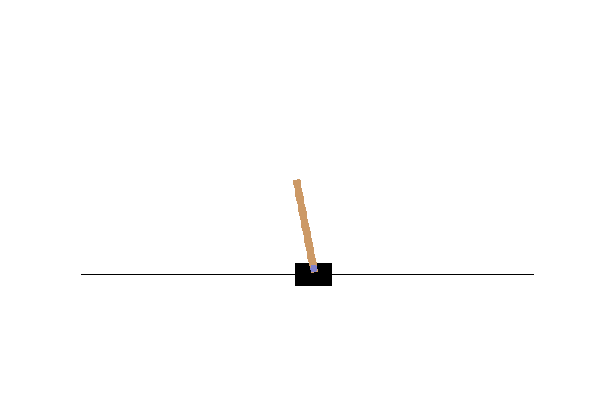
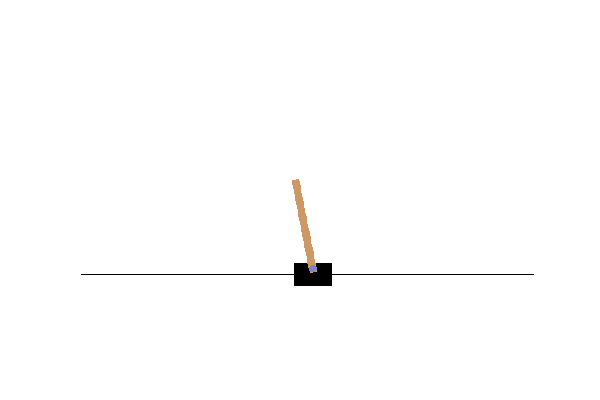
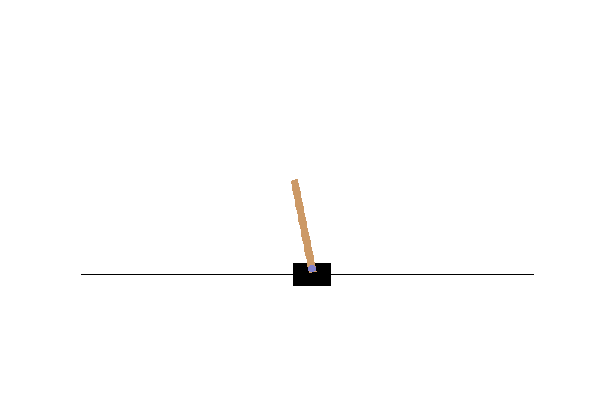
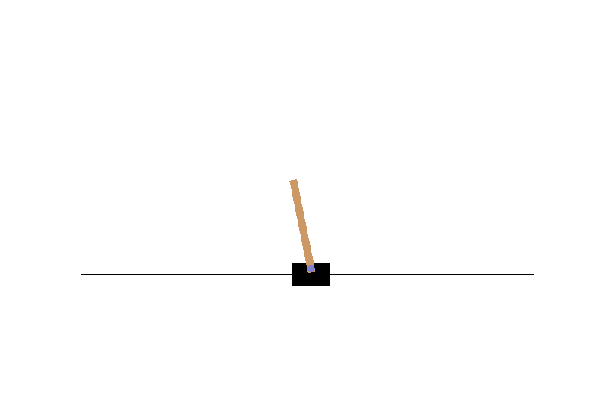
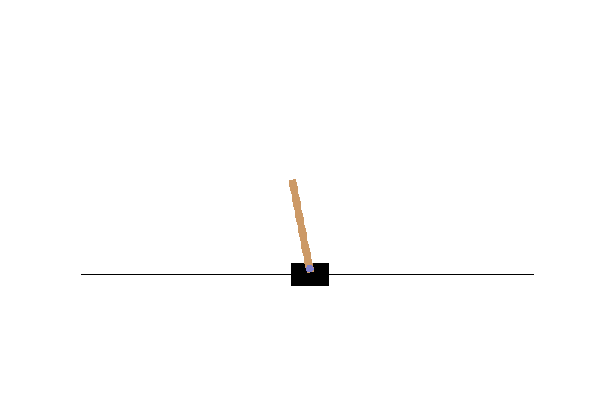
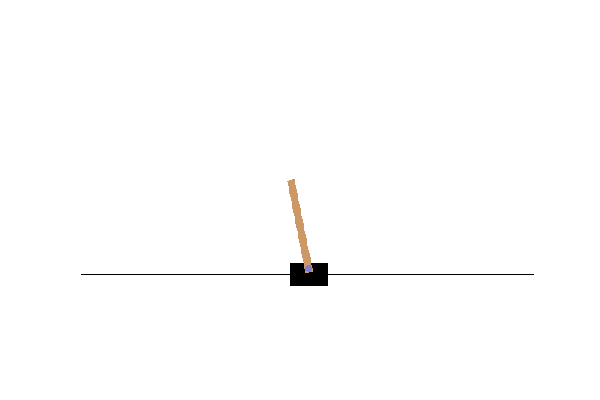
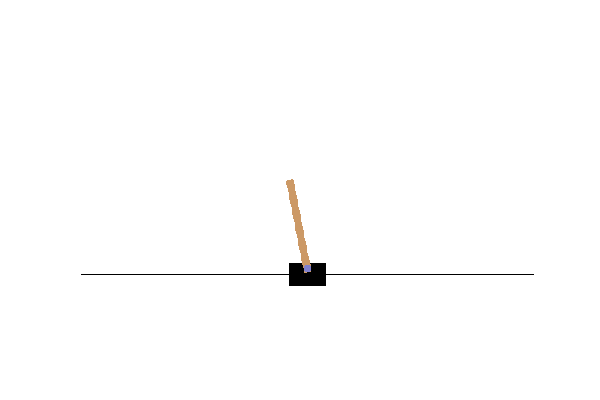
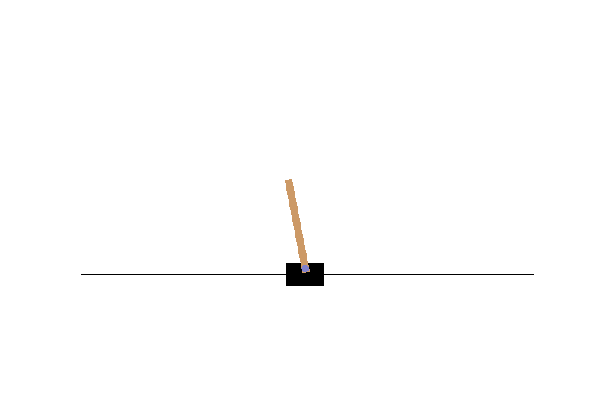
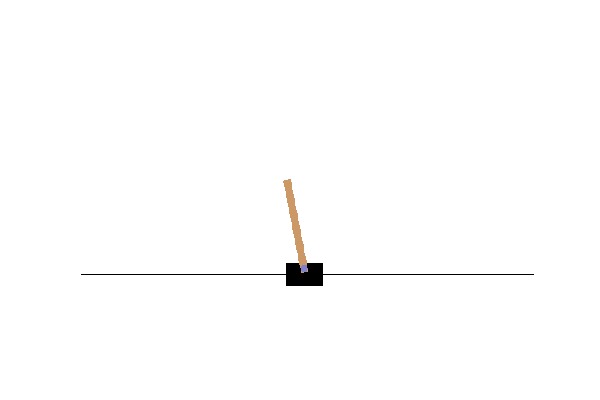
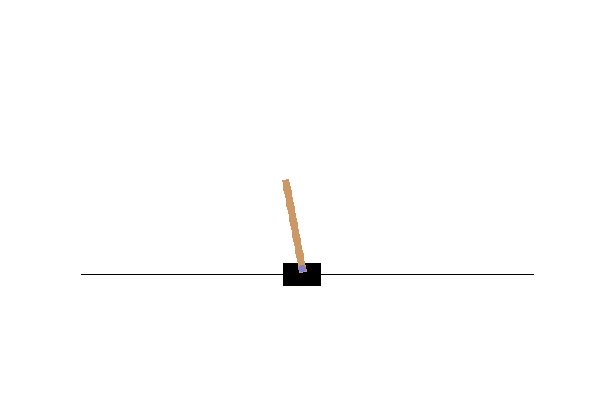
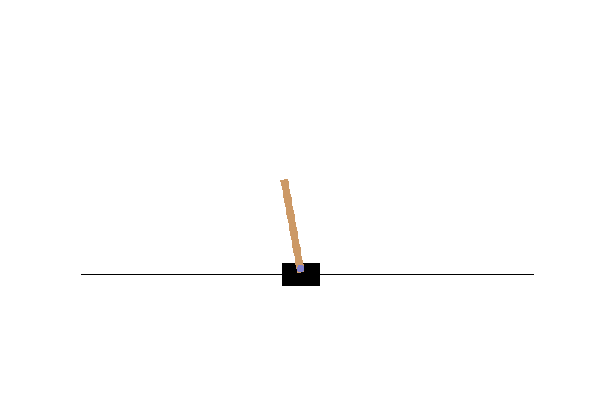
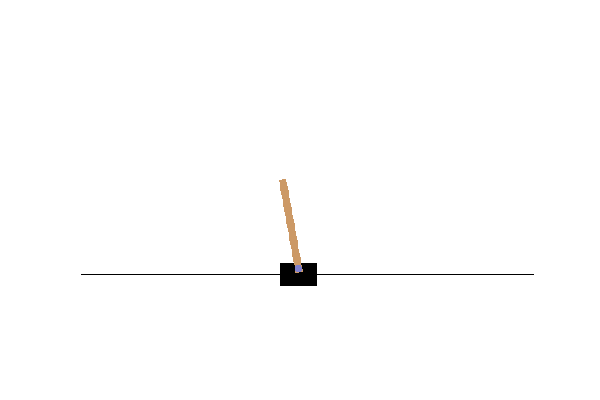
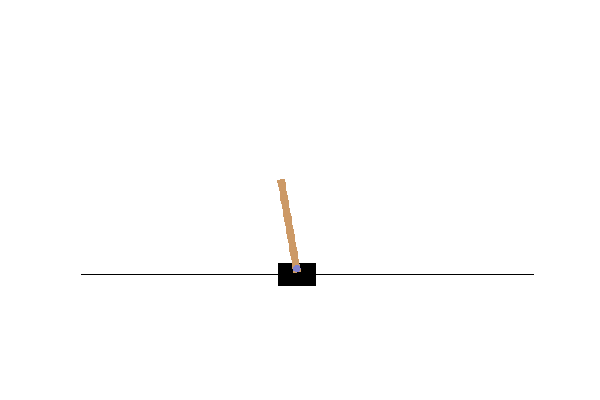
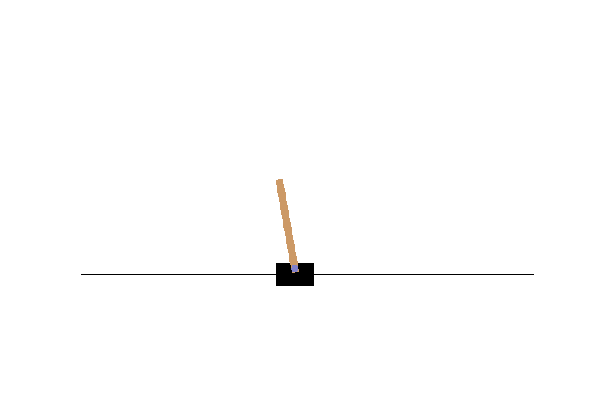
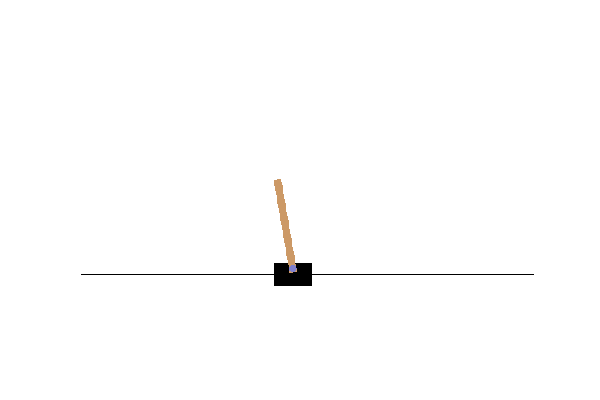
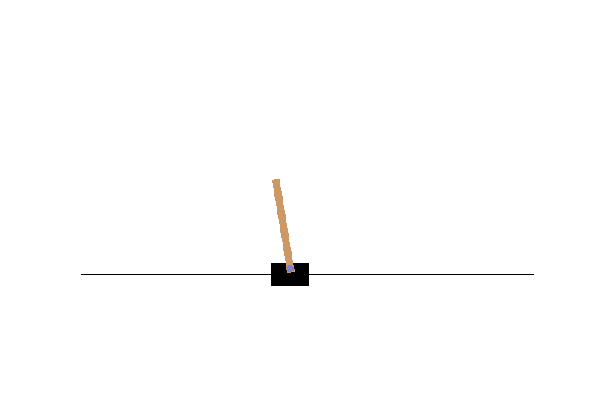
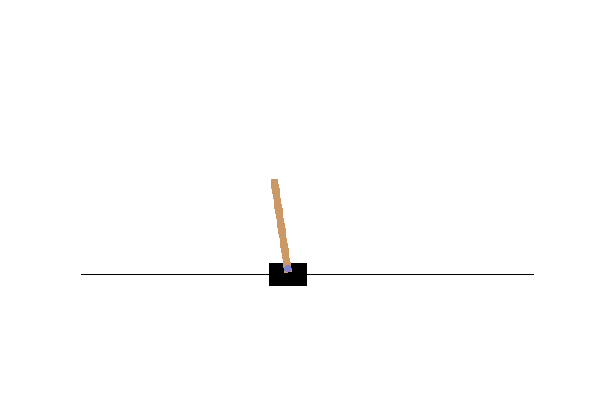
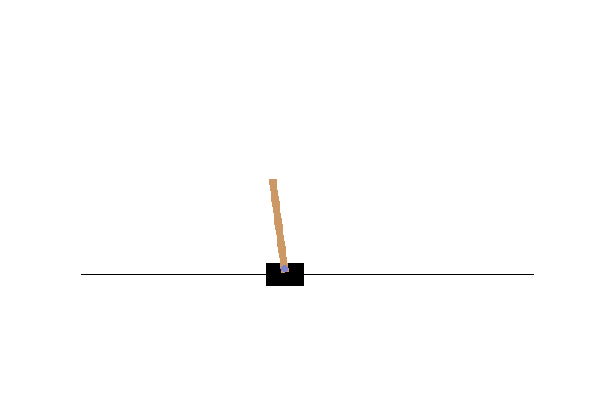
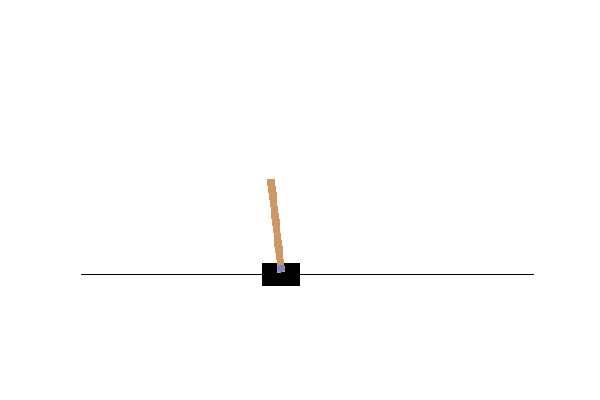
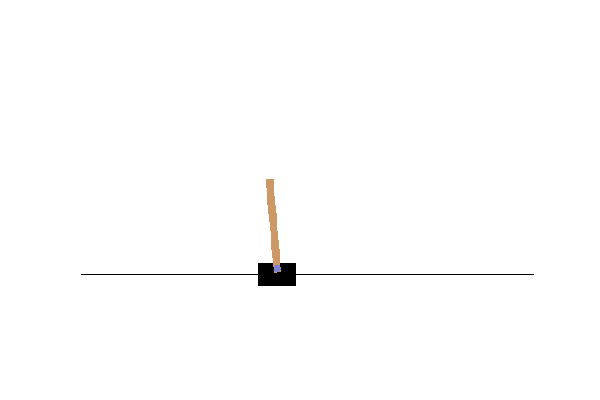
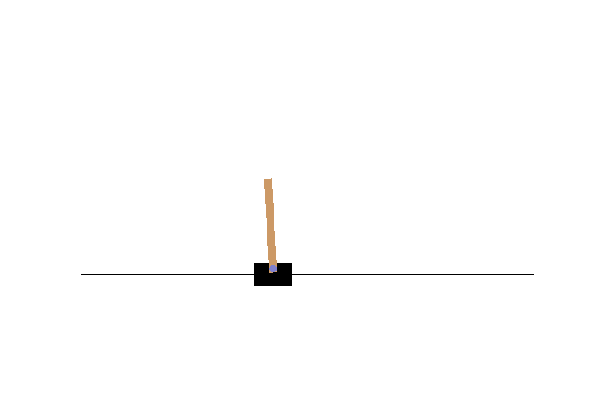
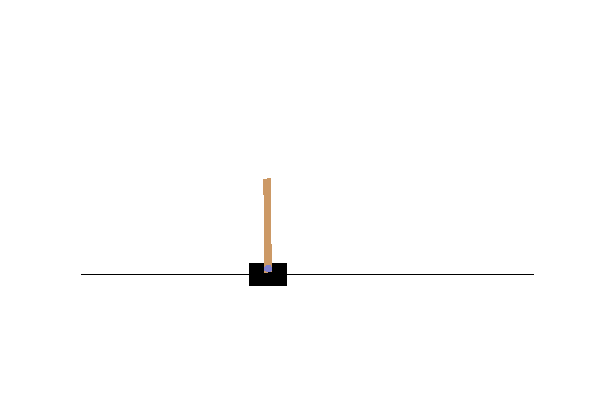
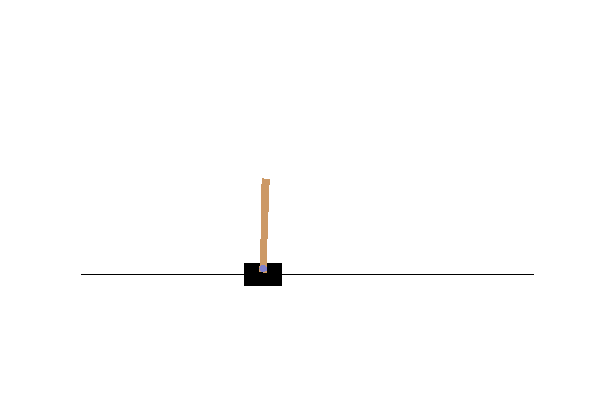
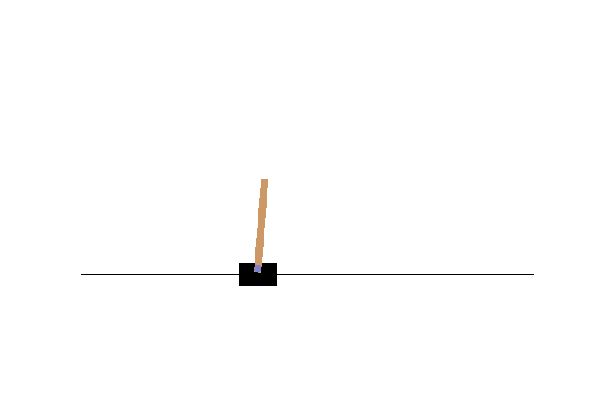
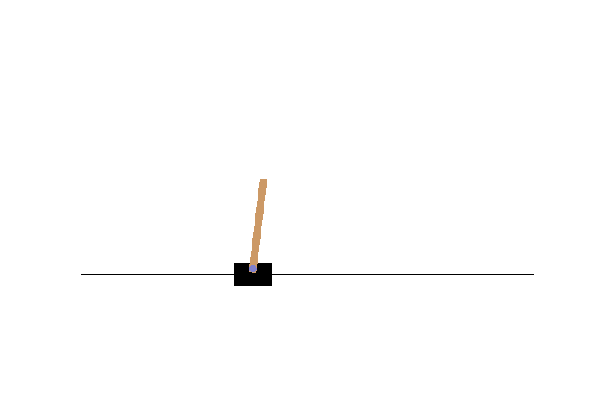
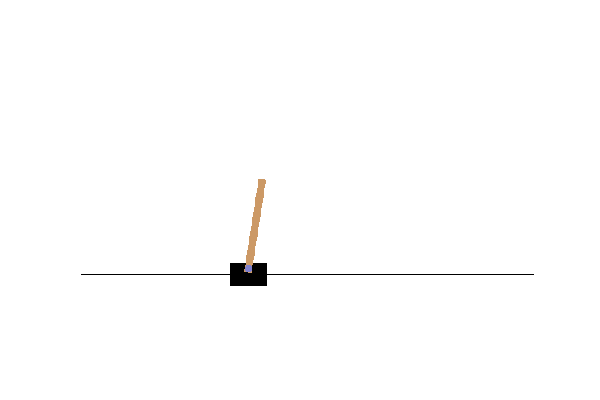
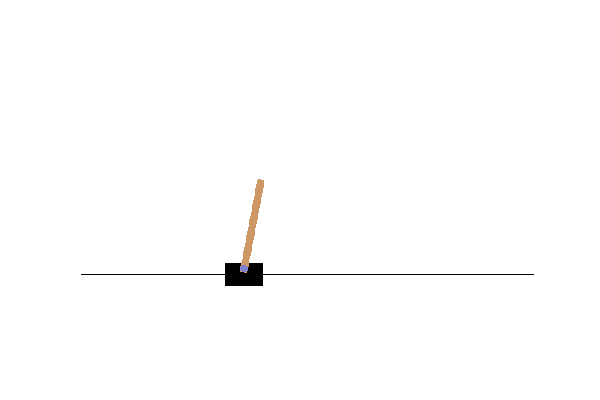

In [14]:
observation = env.reset()
term = False
predicted_q = []
frames = []

### Play till we are dead
while not term:
    rgb_observation = env.render(mode = 'rgb_array')
    frames.append(rgb_observation)
    pred_q = sess.run(predictedreward, feed_dict={networkstate:[observation]})
    predicted_q.append(pred_q)
    action = np.argmax(pred_q)
    observation, _, term, _ = env.step(action)

### Plot the replay!
print("Frames: " + str(len(frames)))
display_frames_as_gif(frames,filename_gif='dqn_run.gif')

### Reinforcement learning tricks


In [19]:
sess = tf.InteractiveSession()
summary_writer = tf.summary.FileWriter('graphs/dqn/normal/'+str(testtrial),sess.graph)
testtrial +=1
sess.run(tf.global_variables_initializer())

In [ ]:
replay_memory = [] # (state, action, reward, terminalstate, state_t+1)
epsilon = 1.0
decay_factor = 0.001
MIN_EPSILON = 0.1

observation = env.reset()

for i_epoch in range(FRAMES_TO_PLAY):
    
    ### Select action
    if random.random() < epsilon:
        action = env.action_space.sample() 
    else:
        pred_q = sess.run(predictedreward, feed_dict={networkstate:[observation]})
        action = np.argmax(pred_q)
    
    ### Anneal epsilon
    epsilon = max(epsilon-decay_factor, MIN_EPSILON)
    
    newobservation, reward, terminal, info = env.step(action)
    ### I prefer that my agent gets 0 reward if it dies
    if terminal: 
        reward = 0
        
    ### Add the observation to our replay memory
    replay_memory.append((observation, action, reward, terminal, newobservation))
    
    ### Reset the environment if the agent died
    if terminal: 
        newobservation = env.reset()
    observation = newobservation
    
    learn(replay_memory)

In [ ]:
observation = env.reset()
term = False
predicted_q = []
frames = []

### Play till we are dead
while not term:
    rgb_observation = env.render(mode = 'rgb_array')
    frames.append(rgb_observation)
    pred_q = sess.run(predictedreward, feed_dict={networkstate:[observation]})
    predicted_q.append(pred_q)
    action = np.argmax(pred_q)
    observation, _, term, _ = env.step(action)

### Plot the replay!
print("Frames: " + str(len(frames)))
display_frames_as_gif(frames,filename_gif='dqn_run.gif')

In [12]:
replay_memory = [] # (state, action, reward, terminalstate, state_t+1)
epsilon = 1.0
BATCH_SIZE = 32
GAMMA = 0.9
MAX_LEN_REPLAY_MEMORY = 30000
FRAMES_TO_PLAY = 300001
MIN_FRAMES_FOR_LEARNING = 1000
summary = None

for i_epoch in range(FRAMES_TO_PLAY):
    
    ### Select an action and perform this
    ### EXERCISE: this is where your network should play and try to come as far as possible!
    ### You have to implement epsilon-annealing yourself
    action = env.action_space.sample() 
    newobservation, reward, terminal, info = env.step(action)

    ### I prefer that my agent gets 0 reward if it dies
    if terminal: 
        reward = 0
        
    ### Add the observation to our replay memory
    replay_memory.append((observation, action, reward, terminal, newobservation))
    
    ### Reset the environment if the agent died
    if terminal: 
        newobservation = env.reset()
    observation = newobservation
    
    ### Learn once we have enough frames to start learning
    if len(replay_memory) > MIN_FRAMES_FOR_LEARNING: 
        experiences = random.sample(replay_memory, BATCH_SIZE)
        totrain = [] # (state, action, delayed_reward)
        
        ### Calculate the predicted reward
        nextstates = [var[4] for var in experiences]
        pred_reward = sess.run(predictedreward, feed_dict={networkstate:nextstates})
        
        ### Set the "ground truth": the value our network has to predict:
        for index in range(BATCH_SIZE):
            state, action, reward, terminalstate, newstate = experiences[index]
            predicted_reward = max(pred_reward[index])
            
            if terminalstate:
                delayedreward = reward
            else:
                delayedreward = reward + GAMMA*predicted_reward
            totrain.append((state, action, delayedreward))
            
        ### Feed the train batch to the algorithm 
        states = [var[0] for var in totrain]
        actions = [var[1] for var in totrain]
        rewards = [var[2] for var in totrain]
        _, l, summary = sess.run([optimizer, loss, merged_summary], feed_dict={networkstate:states, networkaction: actions, networkreward: rewards})


        ### If our memory is too big: remove the first element
        if len(replay_memory) > MAX_LEN_REPLAY_MEMORY:
                replay_memory = replay_memory[1:]

        ### Show the progress 
        summary_writer.add_summary(summary, i_epoch)
        

KeyboardInterrupt: 

## Video 4: Remembering your actions: adding a replay memory


## Video 5: Introduction to the Atari environment
